In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

RootDIR = "/home/jw3514/Work/ASD_Circuits_CellType/" # put this in the right place
os.chdir(RootDIR + "/notebooks_mouse_str") # put this in the right place
print(f"Current working directory: {os.getcwd()}")
sys.path.insert(1, RootDIR + 'src')
# Need to add src directory to Python path first

#sys.path.append("../src")
from ASD_Circuits import *

Current working directory: /home/jw3514/Work/ASD_Circuits_CellType/notebooks_mouse_str


In [2]:
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol = LoadGeneINFO()

str2reg = STR2Region()


In [3]:
ExpZ2Mat = pd.read_csv("../dat/allen-mouse-exp/AllenMouseBrain_Z2bias.csv", index_col=0)

In [4]:
def CountMut(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["GeneEff"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            row["REVEL"] = row["REVEL"].split(";")[0]
            if row["REVEL"] != ".":
                if float(row["REVEL"]) > 0.5:
                    N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn
def Mut2GeneDF(MutDF, PPVs = [0.554, 0.333, 0.138, 0.130], LGD=True, Dmis=True):
    genes = np.array(list(set(MutDF["HGNC"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        Muts = MutDF[MutDF["HGNC"]==g]
        try:
            pLI = float(Muts["ExACpLI"].values[0])
        except:
            pLI = 0
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut(Muts)
        if not LGD:
            N_LGD = 0
        if not Dmis:
            N_Dmis = 0
        if pLI > 0.5:
            gene2MutN[Entrez] = N_LGD * PPVs[0] + N_Dmis * PPVs[1]
        else:
            gene2MutN[Entrez] = N_LGD * PPVs[2] + N_Dmis * PPVs[3]
    return gene2MutN
def GetBiasDat(DF, STRs):
    biases = DF.loc[STRs, "EFFECT"].values
    return np.mean(biases)
def GetBootsDist(DFs, STRs):
    dat = []
    for df in DFs:
        tmp = []
        biases = df.loc[STRs, "EFFECT"].values
        dat.append(np.mean(biases))
    return np.array(dat)
def GetBootErr(DFs1, DFs2, STRs):
    dat = []
    for df1, df2 in zip(DFs1, DFs2):
        tmp = []
        biases1 = df1.loc[STRs, "EFFECT"].values
        biases2 = df2.loc[STRs, "EFFECT"].values
        bias_diff = biases1 - biases2
        dat.append(np.mean(bias_diff))
    return np.array(dat)


# Create Master Table for Phenotype

# IQ and MutType

In [5]:
ASC_IQ_dat = pd.read_excel("../dat/Genetics/1-s2.0-S0092867419313984-mmc4.xlsx", sheet_name="Phenotype") # This is SuppTab from ASC paper
ASC_IQ_dat = ASC_IQ_dat[ASC_IQ_dat["Role"]=="Proband"]
ASC_IQ_dat = ASC_IQ_dat.dropna(subset=['IQ'])

ASC_HIQ = ASC_IQ_dat[ASC_IQ_dat["IQ"]>70]["Phenotype_ID"].values
ASC_LIQ = ASC_IQ_dat[ASC_IQ_dat["IQ"]<=70]["Phenotype_ID"].values

Spark_IQ_dat = pd.read_csv("/home/jw3514/Work/ASD_Phenotype/SPARK_Collection_Version6/core_descriptive_variables.csv")
Spark_IQ_dat = Spark_IQ_dat[Spark_IQ_dat["asd"]==True]
Spark_IQ_dat = Spark_IQ_dat.dropna(subset=['fsiq'])

Spark_HIQ = Spark_IQ_dat[Spark_IQ_dat["fsiq"]>70]["subject_sp_id"].values
Spark_LIQ = Spark_IQ_dat[Spark_IQ_dat["fsiq"]<=70]["subject_sp_id"].values

HighIQ = np.concatenate([ASC_HIQ, Spark_HIQ])
LowIQ = np.concatenate([ASC_LIQ, Spark_LIQ])

ASD_Discov_Muts = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")

ASD_Rep_Muts = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/genes/SPARK/ASD_Rep_DNVs.txt", delimiter="\t")
ASD_Rep_Trios = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/genes/SPARK/ASD_Rep_Trios.txt", delimiter="\t")

ASD_Muts = pd.concat([ASD_Discov_Muts, ASD_Rep_Muts])
ASD_Trios = pd.concat([ASD_Discov_Trios, ASD_Rep_Trios])

Spark_Meta_2stage = pd.read_excel("/home/jw3514/Work/ASD_Circuits/dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_HC = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]
#Spark_Meta_HC = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1e-3]
HighConfGenes = Spark_Meta_HC["HGNC"].values
HighConfMuts = ASD_Muts[ASD_Muts["HGNC"].isin(HighConfGenes)]
HighConfMuts = Filt_LGD_Mis(HighConfMuts, Dmis=True)


HIQ_Muts = HighConfMuts[HighConfMuts["IID"].isin(HighIQ)]
LIQ_Muts = HighConfMuts[HighConfMuts["IID"].isin(LowIQ)]

/home/jw3514/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/tmp/ipykernel_3021572/1461867450.py:8: DtypeWarning: Columns (19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  Spark_IQ_dat = pd.read_csv("/home/jw3514/Work/ASD_Phenotype/SPARK_Collection_Version6/core_descriptive_variables.csv")


In [6]:
print(HIQ_Muts.shape, LIQ_Muts.shape)

(102, 44) (119, 44)


###### IQ Distribution

81.32026550508193
78.9237621540763


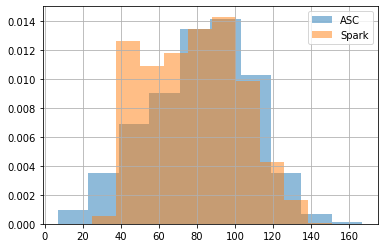

In [7]:
ASC_IQ_dat["IQ"].hist(label="ASC", density=1, alpha=0.5)
print(ASC_IQ_dat["IQ"].mean())

Spark_IQ_dat["fsiq"].hist(label="Spark", density=1, alpha=0.5)
print(Spark_IQ_dat["fsiq"].mean())

plt.legend()

Text(0.5, 0, 'FSIQ')

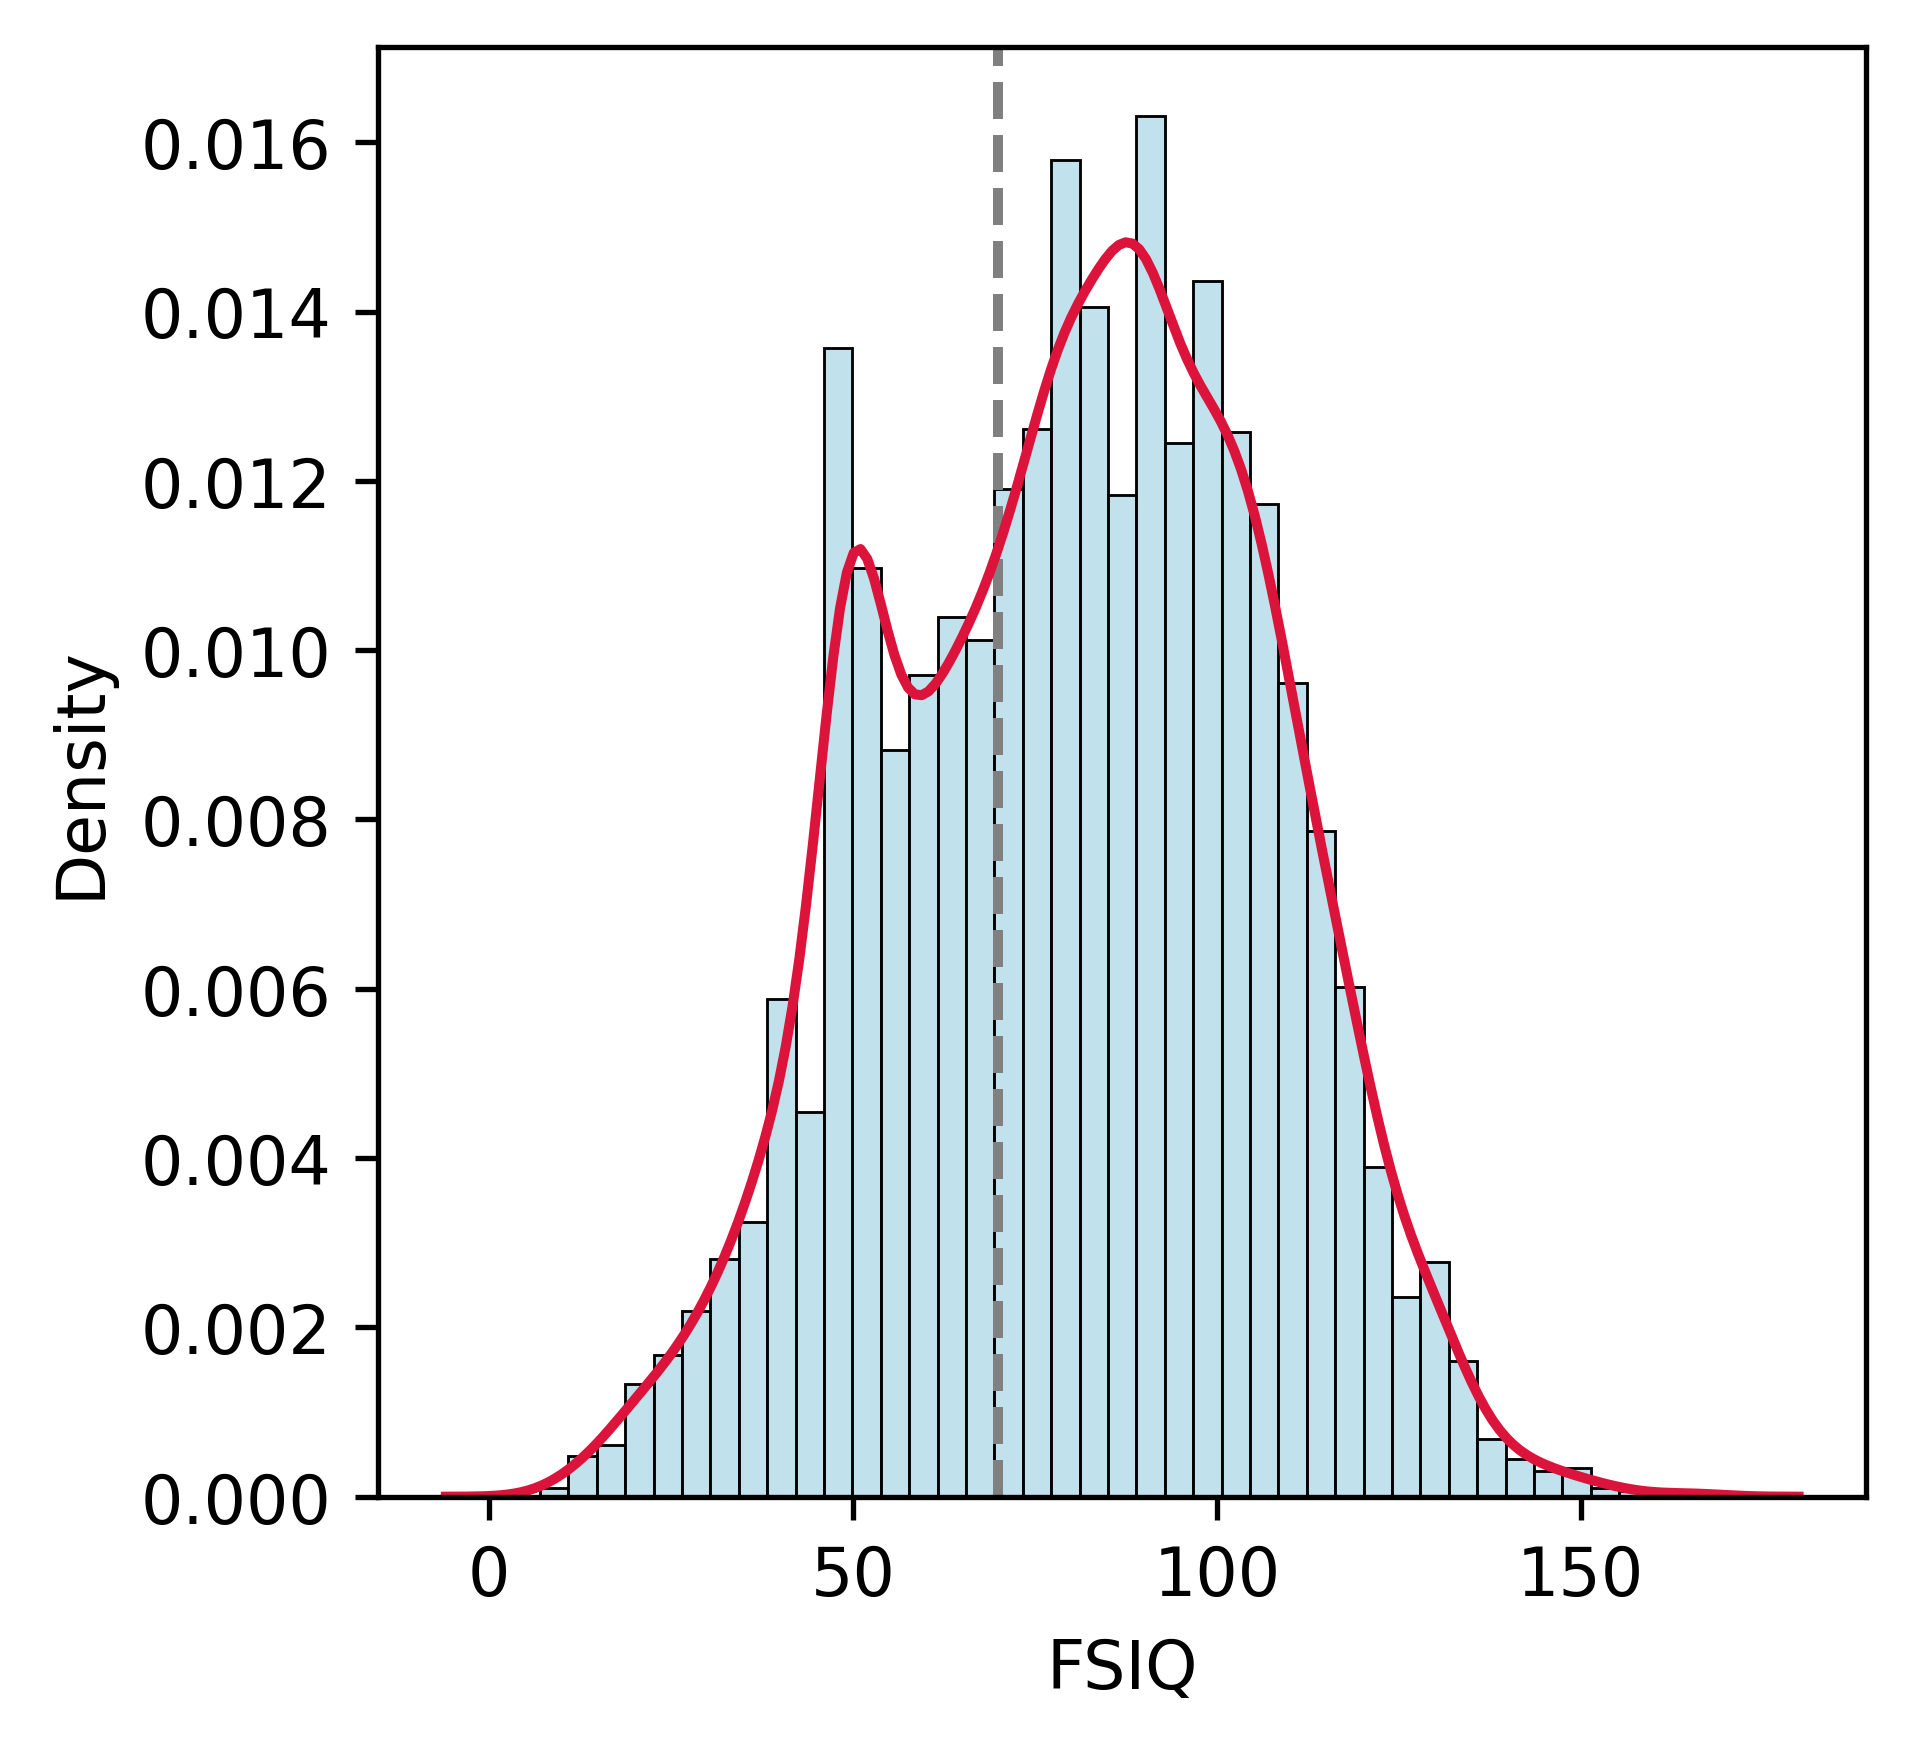

In [8]:
IQs = list(ASC_IQ_dat["IQ"].values) + list(Spark_IQ_dat["fsiq"].values)
fig, ax = plt.subplots(dpi=480, figsize=(4,4))
ax.axvline(x=70, color="grey", ls="dashed")
sns.kdeplot(IQs, color="crimson")
sns.histplot(IQs, stat="density", color="lightblue")
plt.xlabel("FSIQ")

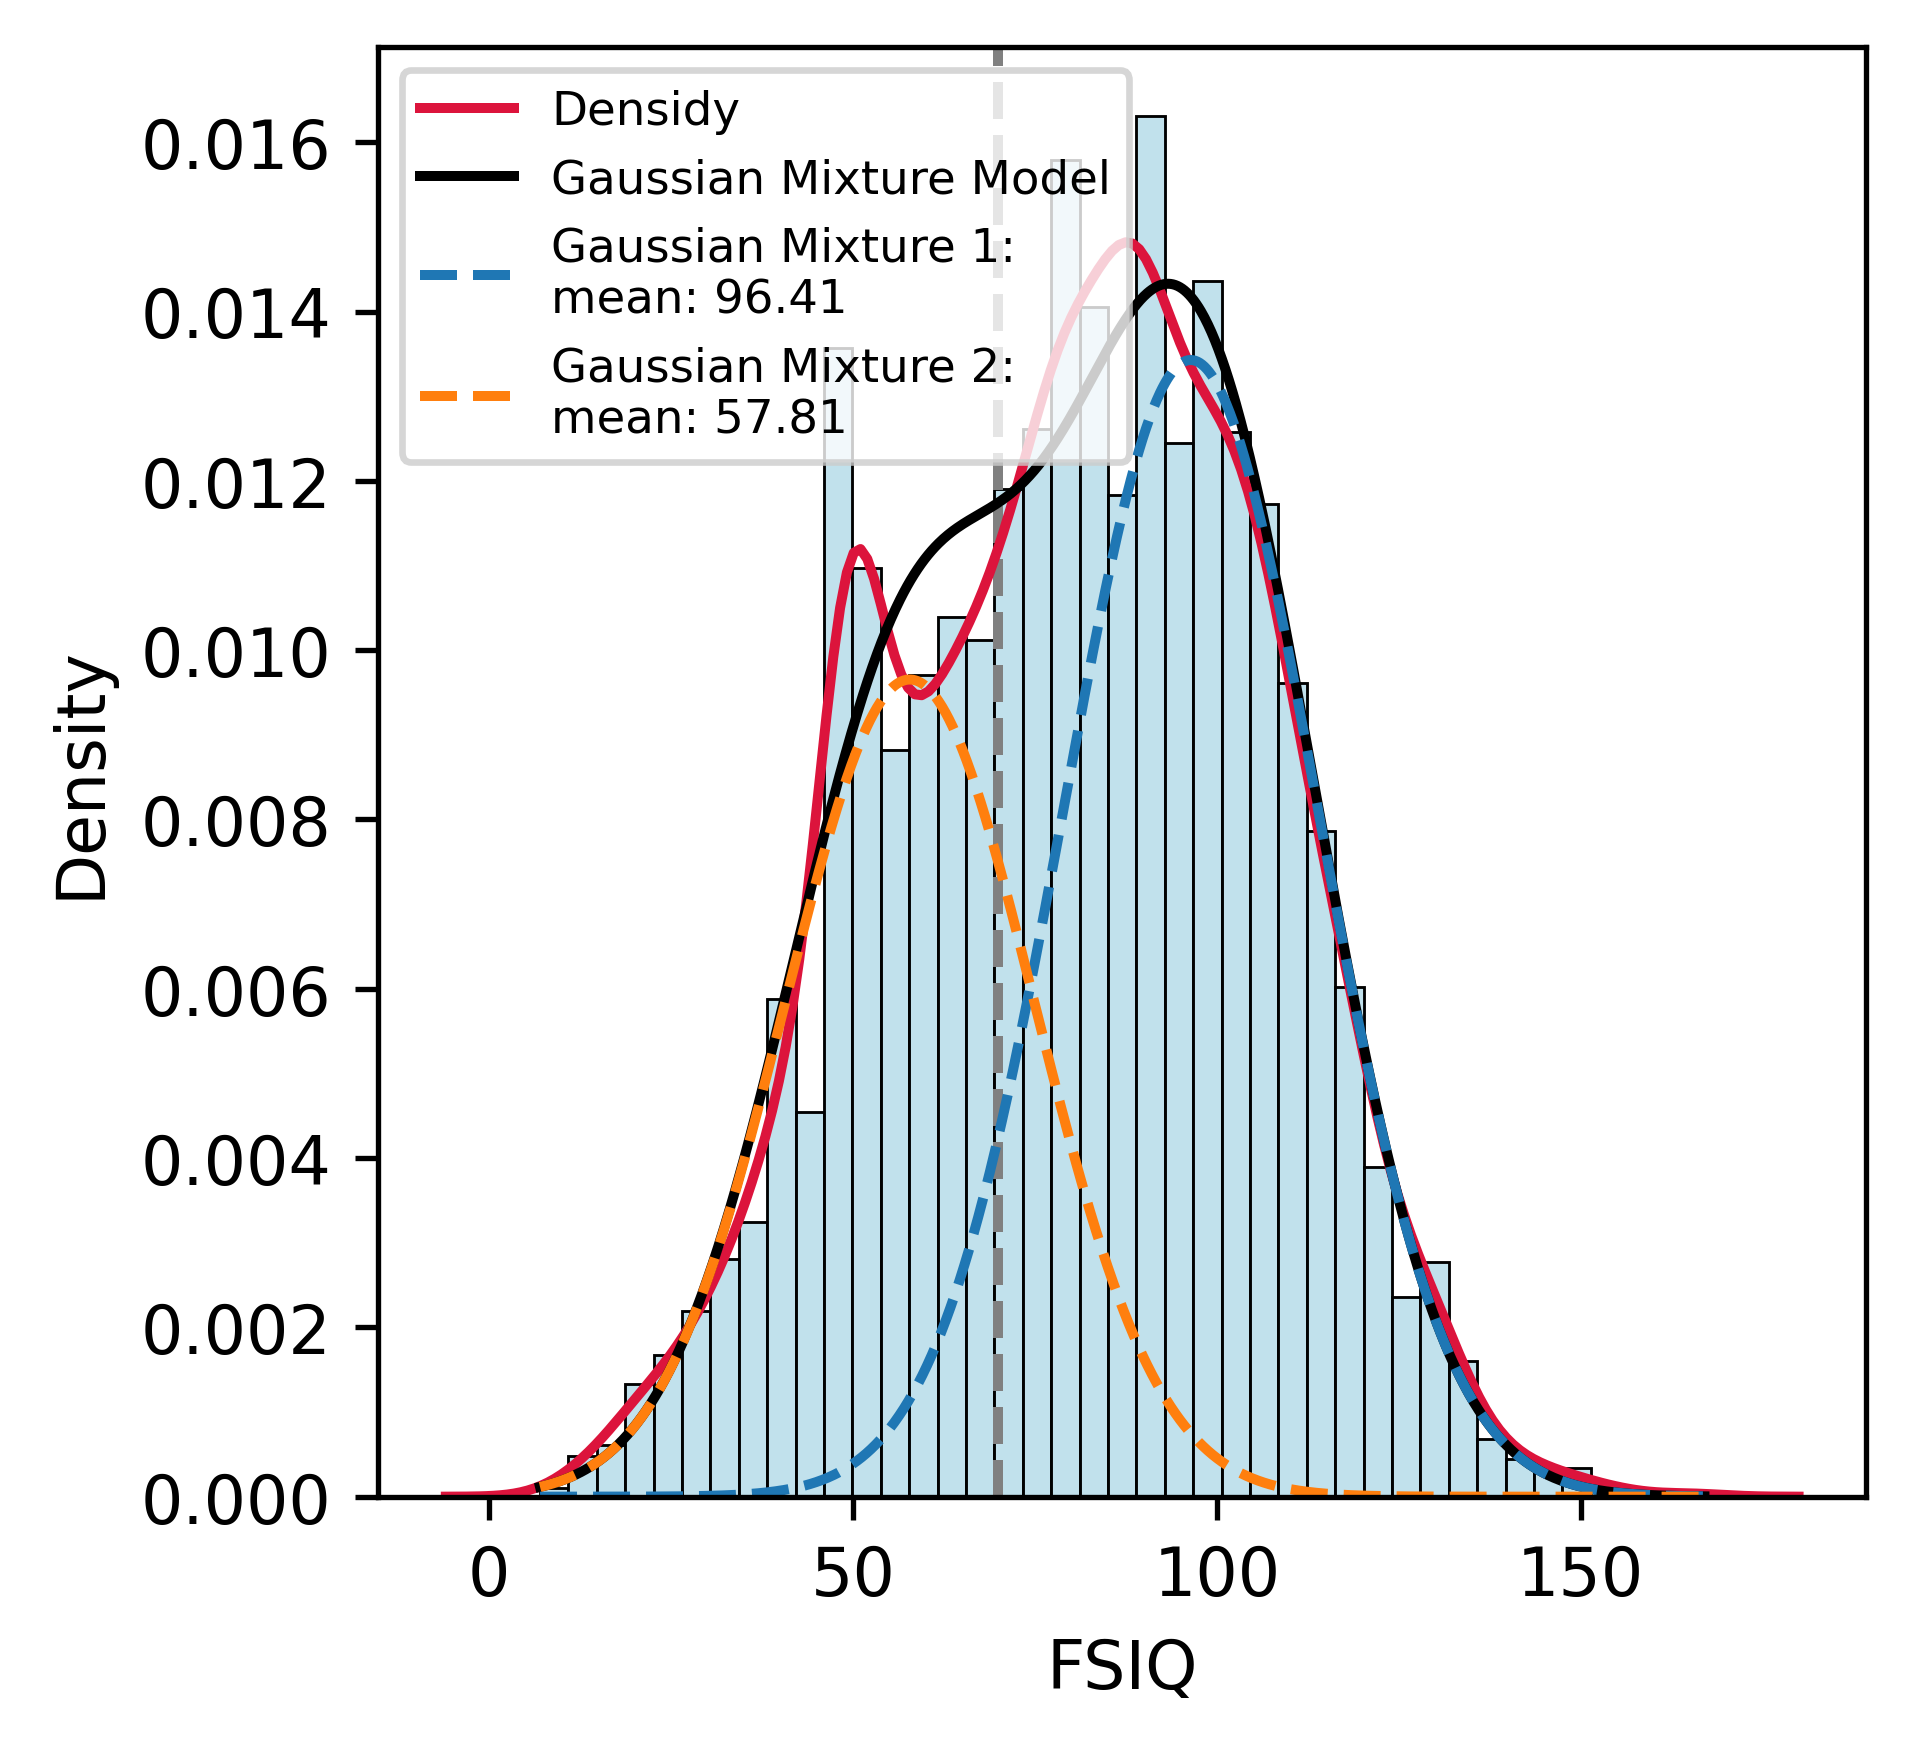

In [9]:
from sklearn.mixture import GaussianMixture
import numpy as np

IQs = list(ASC_IQ_dat["IQ"].values) + list(Spark_IQ_dat["fsiq"].values)
IQs = np.array(IQs).reshape(-1, 1)

gmm = GaussianMixture(n_components=2)
gmm.fit(IQs)
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()

fig, ax = plt.subplots(dpi=480, figsize=(4,4))
ax.axvline(x=70, color="grey", ls="dashed")
sns.kdeplot(IQs.flatten(), color="crimson", label="Densidy")
sns.histplot(IQs.flatten(), stat="density", color="lightblue")

x = np.linspace(min(IQs), max(IQs), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
ax.plot(x, pdf, '-k', label='Gaussian Mixture Model')

# Plot density of each Gaussian component separately
i = 1
for mean, covar, weight in zip(means, covariances, weights):
    component_pdf = weight * (1/np.sqrt(2 * np.pi * covar)) * np.exp(-0.5 * ((x - mean) ** 2) / covar)
    ax.plot(x, component_pdf, '--', label=f'Gaussian Mixture {i}: \nmean: {mean:.2f}')
    i += 1

plt.xlabel("FSIQ")
plt.legend(fontsize=7)

96.45090797168359
94.46167178856793


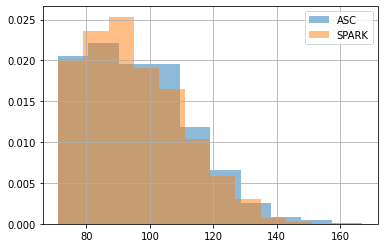

In [10]:
tmp1 = ASC_IQ_dat[ASC_IQ_dat["IQ"]>70]
tmp1["IQ"].hist(label="ASC", density=1, alpha=0.5)
print(tmp1["IQ"].mean())

tmp2 = Spark_IQ_dat[Spark_IQ_dat["fsiq"]>70]
tmp2["fsiq"].hist(label="SPARK", density=1, alpha=0.5)
print(tmp2["fsiq"].mean())
plt.legend()

49.487246566383256
54.063


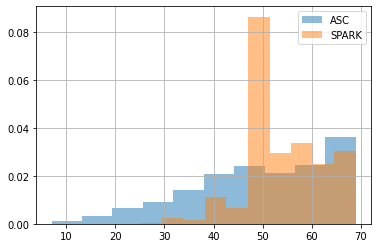

In [11]:
tmp1 = ASC_IQ_dat[ASC_IQ_dat["IQ"]<70]
tmp1["IQ"].hist(label="ASC", density=1, alpha=0.5)
print(tmp1["IQ"].mean())

tmp2 = Spark_IQ_dat[Spark_IQ_dat["fsiq"]<70]
tmp2["fsiq"].hist(label="SPARK", density=1, alpha=0.5)
print(tmp2["fsiq"].mean())
plt.legend()

# Structural IQ Stratified Bias

In [17]:
#HIQ_Muts.to_csv("../dat/Unionize_bias/Pheno.HighIQ.Highconf.Muts.csv", index=False)
#LIQ_Muts.to_csv("../dat/Unionize_bias/Pheno.LowIQ.Highconf.Muts.csv", index=False)

In [12]:
#HIQ_GW = Mut2GeneDF(HIQ_Muts, PPVs=HIQ_Rate) # Not use weights input
HIQ_GW = Mut2GeneDF(HIQ_Muts, LGD=True, Dmis=True) 
HIQ_GW_LGD = Mut2GeneDF(HIQ_Muts, LGD=True, Dmis=False) 
HIQ_GW_Dmis = Mut2GeneDF(HIQ_Muts, LGD=False, Dmis=True) 

Dict2Fil(HIQ_GW, "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/ASD.HIQ.gw.csv")
HIQ_DF = AvgSTRZ_Weighted(ExpZ2Mat, HIQ_GW, 
                                 Method = 1, csv_fil = "../dat/Unionize_bias/ASD.HIQ_spec.bias.csv")

#LIQ_GW = Mut2GeneDF(LIQ_Muts, PPVs=LIQ_Rate)
LIQ_GW = Mut2GeneDF(LIQ_Muts, LGD=True, Dmis=True)
Dict2Fil(LIQ_GW, "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/ASD.LIQ.gw.csv")
LIQ_DF = AvgSTRZ_Weighted(ExpZ2Mat, LIQ_GW, 
                                 Method = 1, csv_fil = "../dat/Unionize_bias/ASD.LIQ_spec.bias.csv")

##HIQ_DF = HIQ_DF.set_index("STR")
#HIQ_LGD = HIQ_LGD.set_index("STR")
#HIQ_Dmis = HIQ_Dmis.set_index("STR")
#LIQ_DF = LIQ_DF.set_index("STR")
#LIQ_LGD = LIQ_LGD.set_index("STR")
#LIQ_Dmis = LIQ_Dmis.set_index("STR")

In [13]:
ASD_CircuitsSet = pd.read_csv(
    "/home/jw3514/Work/ASD_Circuits/notebooks/ASD.SA.Circuits.Size46.csv",
    index_col="idx")
ASD_Circuits = ASD_CircuitsSet.loc[3, "STRs"].split(";")
#ASD_Circuits.append("Field_CA3")

#CIR_REGIONS = ['Isocortex', 'Hippocampus', 
#     'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Olfactory_areas']
CIR_REGIONS = ['Isocortex', 'Hippocampus', 
     'Amygdala', 'Striatum', 'Thalamus', 'Olfactory_areas']
#CIR_REGIONS = ['Isocortex', 'Hippocampus', 
#     'Amygdala', 'Striatum', 'Thalamus']

CIR_REGIONS_Dict = {}
for i in range(len(CIR_REGIONS)):
    CIR_REGIONS_Dict[CIR_REGIONS[i]] = []
for _str in ASD_Circuits:
    for i in range(len(CIR_REGIONS)):
        if str2reg[_str] == CIR_REGIONS[i]:
            CIR_REGIONS_Dict[CIR_REGIONS[i]].append(_str)
            break
CIR_REGIONS_Dict["Amygdala"].append("Bed_nuclei_of_the_stria_terminalis")

In [14]:
ASD_CircuitsSet

,Bias,SI_score,Conn_score,gain STRs,lost STRs,STRs
idx,,,,,,
0,0.382480,0.504659,0.120983,NaN,NaN,Nucleus_accumbens;Orbital_area_lateral_part;Pr...
1,0.380007,0.559579,0.137996,Orbital_area_medial_part;Subiculum_dorsal_part...,Subparafascicular_nucleus_magnocellular_part;E...,Nucleus_accumbens;Orbital_area_lateral_part;Pr...
2,0.375025,0.648956,0.157372,Basolateral_amygdalar_nucleus;Entorhinal_area_...,Parasubiculum;Supplemental_somatosensory_area;...,Nucleus_accumbens;Orbital_area_lateral_part;Pr...
3,0.370075,0.700738,0.169660,Anterior_cingulate_area_ventral_part;Anteromed...,Field_CA3;Visceral_area;Lateral_septal_nucleus...,Nucleus_accumbens;Orbital_area_lateral_part;Pr...
4,0.365139,0.729025,0.177221,Field_CA3;Taenia_tecta,Dentate_gyrus;Field_CA1,Nucleus_accumbens;Orbital_area_lateral_part;Pr...
5,0.360054,0.762260,0.185728,Primary_somatosensory_area_barrel_field;Supple...,Field_CA3;Taenia_tecta;Field_CA2,Nucleus_accumbens;Orbital_area_lateral_part;Pr...
6,0.355188,0.791042,0.192817,Taenia_tecta;Frontal_pole_cerebral_cortex,Agranular_insular_area_posterior_part;Basomedi...,Nucleus_accumbens;Orbital_area_lateral_part;Pr...
7,0.350317,0.809086,0.196597,Posterior_complex_of_the_thalamus,Lateral_amygdalar_nucleus,Nucleus_accumbens;Orbital_area_lateral_part;Pr...
8,0.345115,0.820765,0.201323,Central_lateral_nucleus_of_the_thalamus;Antero...,Lateral_septal_nucleus_rostral_rostroventral_p...,Nucleus_accumbens;Orbital_area_lateral_part;Pr...


In [15]:
print(RegionDistributionsList(ASD_Circuits))

Cortical_subplate	2	Claustrum; Endopiriform_nucleus_dorsal_part
Pallidum	1	Bed_nuclei_of_the_stria_terminalis
Amygdala	3	Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Olfactory_areas	3	Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_area
Hippocampus	6	Dentate_gyrus; Field_CA2; Subiculum_ventral_part; Field_CA1; Subiculum_dorsal_part; Entorhinal_area_lateral_part
Midbrain	1	Anterior_pretectal_nucleus
Thalamus	8	Parafascicular_nucleus; Nucleus_of_reuniens; Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Parataenial_nucleus; Mediodorsal_nucleus_of_thalamus; Anteromedial_nucleus_dorsal_part
Striatum	3	Nucleus_accumbens; Caudoputamen; Lateral_septal_nucleus_rostral_rostroventral_part
Isocortex	19	Orbital_area_lateral_part; Prelimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Infralimbic_area; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_p

In [16]:
HIQ_Cir = HIQ_DF.loc[ASD_Circuits,:]
LIQ_Cir = LIQ_DF.loc[ASD_Circuits,:]
HIQ_Cir.loc["Bed_nuclei_of_the_stria_terminalis", "REGION"] = "Amygdala"
LIQ_Cir.loc["Bed_nuclei_of_the_stria_terminalis", "REGION"] = "Amygdala"

### Individual STRs

In [17]:
IQ_PhenotypeDF = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/IQ_Bias_Diff.Pvalues.csv", index_col="STR")

In [18]:
IQ_PhenotypeDF.head(2)

,REG,HighIQ Bias,LowIQ Bias,HighIQ Rank,LowIQ Rank,Bias Diff (low-high),Rank Diff,Pvalue
STR,,,,,,,,
Nucleus_accumbens,Striatum,0.350765,0.640720,10,1,0.289955,-9,0.013299
Orbital_area_lateral_part,Isocortex,0.247823,0.537487,25,11,0.289664,-14,0.011799


In [19]:
import re
from matplotlib.markers import TICKDOWN
def PlotPhenotype(Dat1, Err1, Dat2, Err2, REG, IQ_PhenotypeDF, label1="", label2 = "", fig_size=0):
    #sort_idx = np.argsort(HighIQ_dat)
    Pvalues = IQ_PhenotypeDF.loc[Dat1.index.values, "Pvalue"].values
    sort_idx = np.argsort(Dat1["EFFECT"].values)
    X = np.arange(Dat1.shape[0])
    if fig_size == 0:
        fig_size = (2.5 + 0.4 * Dat1.shape[0], 6)
    print(fig_size)
    fig, ax = plt.subplots(dpi=120, figsize = fig_size)
    
    dat1 = Dat1["EFFECT"].values[sort_idx]
    err1 = Err1[sort_idx]
    dat2 = Dat2["EFFECT"].values[sort_idx]
    err2 = Err2[sort_idx]
    
    bar_width = 0.3
    ax.bar(X - 0.15, dat1, yerr = err1, color="#AED6F1", width=0.3, label=label1, 
           edgecolor ='black')
    ax.bar(X + 0.15, dat2, yerr = err2, color="#21618C", width=0.3, label=label2, 
       edgecolor ='black', hatch="")
    
    Pvalues = Pvalues[sort_idx]
    offset  = 0.05
    for i,p in enumerate(Pvalues):
        if p>=0.05:
            continue
        elif p<0.001:
            displaystring = r'***'
        elif p<0.01:
            displaystring = r'**'
        else:
            displaystring = r'*'

        height = offset +  max(dat1[i] + err1[i], dat2[i]+err2[i])
        bar_centers = X[i]-0.3 + np.array([0.5,1.5])*bar_width
        significance_bar(bar_centers[0],bar_centers[1],height,displaystring)
    
    ax.set_xlabel('', fontweight ='bold', fontsize = 15)
    ax.set_ylabel('Expression Bias', fontsize = 15)
    plt.xticks(X, drop_fromList(Dat1.index.values[sort_idx]), rotation=45, fontsize=10, ha='right', rotation_mode="anchor")

    #ax.legend(loc="best", fontsize=15)
    plt.title(" ".join(REG.split("_")), fontsize=20)
    plt.tight_layout()
    ax.set_ylim(-0.2, 0.84)
    ax.grid(True, axis="y", alpha=0.5)
    ax.set_axisbelow(True)      
    plt.show()
    
def significance_bar(start,end,height,displaystring,linewidth = 1.2,
                     markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth, marker = TICKDOWN,
             markeredgewidth=linewidth, markersize = markersize)
    
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height + 0.03, displaystring, ha = 'center',va='center',)
             #bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)
    
def PlotPhenotypeV2(HIQ_Male_dat, HIQ_Female_dat, LIQ_Male_dat, LIQ_Female_dat, REG):
    X = np.arange(HIQ_Male_dat.shape[0])
    fig, ax = plt.subplots(dpi=120, figsize = (8+ HIQ_Male_dat.shape[0]/2, 6))
    ax.bar(X - 0.2, HIQ_Male_dat["EFFECT"], color="#F1948A", width=0.15, label="HIQ LGD", 
           edgecolor ='black')
    ax.bar(X - 0.05, HIQ_Female_dat["EFFECT"], color="#AED6F1", width=0.15, label="HIQ Dmis", 
       edgecolor ='black', hatch="")

    ax.bar(X + 0.1, LIQ_Male_dat["EFFECT"], color="#B03A2E", width=0.15, label="LIQ LGD", 
           edgecolor ='black')
    ax.bar(X + 0.25, LIQ_Female_dat["EFFECT"], color="#21618C", width=0.15, label="LIQ Dmis", 
       edgecolor ='black', hatch="")

    ax.set_xlabel('', fontweight ='bold', fontsize = 20)
    ax.set_ylabel('Expression Bias', fontsize = 20)
    plt.xticks(X, HIQ_Male_dat.index.values, rotation=45, fontsize=10, ha='right', rotation_mode="anchor")

    ax.legend(loc="upper left")
    plt.tight_layout()
    #ax.set_ylim(-0.1, 0.95)
    ax.grid(True, axis="y", alpha=0.5)
    ax.set_axisbelow(True)     
    plt.title(REG)
    plt.show()  
    
def PlotPhenotypeV3(HIQ_Male_dat, HIQ_Male_err, HIQ_Female_dat, HIQ_Female_err, 
                    LIQ_Male_dat, LIQ_Male_err, LIQ_Female_dat, LIQ_Female_err, REG):
    X = np.arange(HIQ_Male_dat.shape[0])
    fig, ax = plt.subplots(dpi=120, figsize = (4+ HIQ_Male_dat.shape[0]/2, 6))
    ax.bar(X - 0.2, HIQ_Male_dat["EFFECT"], yerr = HIQ_Male_err, color="#F1948A", width=0.15, label="HIQ LGD", 
           edgecolor ='black')
    ax.bar(X - 0.05, HIQ_Female_dat["EFFECT"], yerr = HIQ_Female_err, color="#AED6F1", width=0.15, label="HIQ Dmis", 
       edgecolor ='black', hatch="")

    ax.bar(X + 0.1, LIQ_Male_dat["EFFECT"], yerr = LIQ_Male_err, color="#B03A2E", width=0.15, label="LIQ LGD", 
           edgecolor ='black')
    ax.bar(X + 0.25, LIQ_Female_dat["EFFECT"], yerr = LIQ_Female_err, color="#21618C", width=0.15, label="LIQ Dmis", 
       edgecolor ='black', hatch="")

    ax.set_xlabel('', fontweight ='bold', fontsize = 20)
    ax.set_ylabel('Expression Bias', fontsize = 20)
    plt.xticks(X, HIQ_Male_dat.index.values, rotation=45, fontsize=10, ha='right', rotation_mode="anchor")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.8))
    plt.tight_layout()
    #ax.set_ylim(-0.1, 0.95)
    ax.grid(True, axis="y", alpha=0.5)
    ax.set_axisbelow(True)     
    plt.title(REG)
    plt.show()  
    
def GetBootsDist_STR(DFs, STR):
    dat = []
    for df in DFs:
        tmp = []
        biases = df.loc[STR, "EFFECT"]
        dat.append(np.mean(biases))
    return np.array(dat)

In [22]:
HIQ_BootDFs = []
for i in range(1,1001,1):
    df1 = pd.read_csv('/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/Bootstrap/ASD.HIQ/boot.bias.ALL.{}.csv'.format(i), index_col="STR")
    HIQ_BootDFs.append(df1)

LIQ_BootDFs = []
for i in range(1,1001,1):
    df1 = pd.read_csv('/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/Bootstrap/ASD.LIQ/boot.bias.ALL.{}.csv'.format(i), index_col="STR")
    LIQ_BootDFs.append(df1)

In [25]:
HIQ_dat = []
LIQ_dat = []
HIQ_err = []
LIQ_err = []
for REG in CIR_REGIONS:
    HIQ_dat.append(HIQ_Cir[HIQ_Cir["REGION"]==REG]["EFFECT"].mean())
    LIQ_dat.append(LIQ_Cir[LIQ_Cir["REGION"]==REG]["EFFECT"].mean())
    HIQ_err.append(np.std(GetBootsDist(HIQ_BootDFs, CIR_REGIONS_Dict[REG])))
    LIQ_err.append(np.std(GetBootsDist(LIQ_BootDFs, CIR_REGIONS_Dict[REG])))

HIQ_dat = np.array(HIQ_dat)
LIQ_dat = np.array(LIQ_dat)
HIQ_err = np.array(HIQ_err)    
LIQ_err = np.array(LIQ_err)   

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U14')) -> None

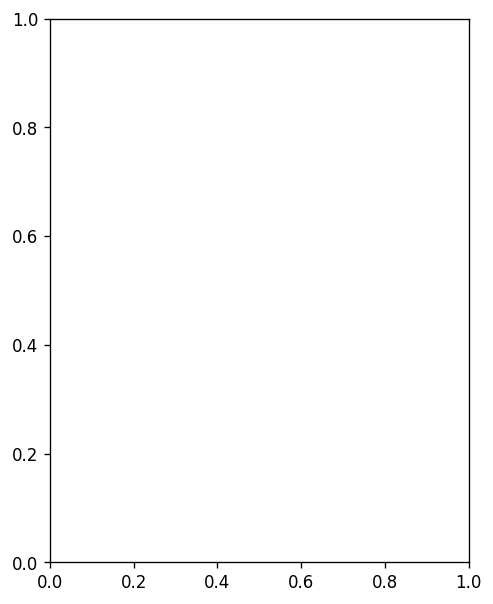

In [27]:
REG = 'Amygdala'
HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
REG_STRs = HIQ_ALL_dat.index.values
HIQ_STR_Errors = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
LIQ_STR_Errors = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
#print(HIQ_ALL_err)
PlotPhenotype(HIQ_ALL_dat, HIQ_STR_Errors, LIQ_ALL_dat, LIQ_STR_Errors, REG, IQ_PhenotypeDF,
              "Higher IQ Bias", "Lower IQ Bias", fig_size=(4.5,6))

In [30]:
def drop_fromList(_list):
    return [" ".join(x.split("_")) for x in _list]

(12, 6)


<Figure size 5760x3840 with 0 Axes>

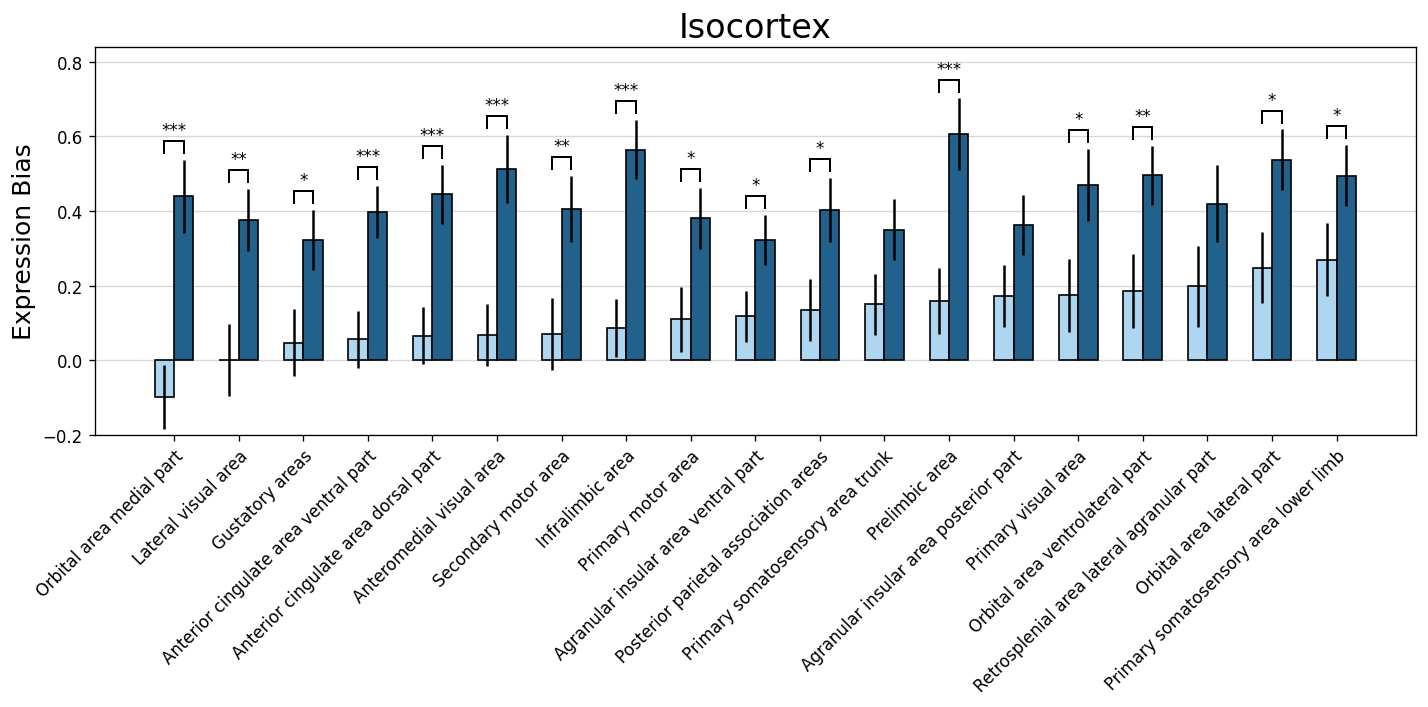

(5.5, 6)


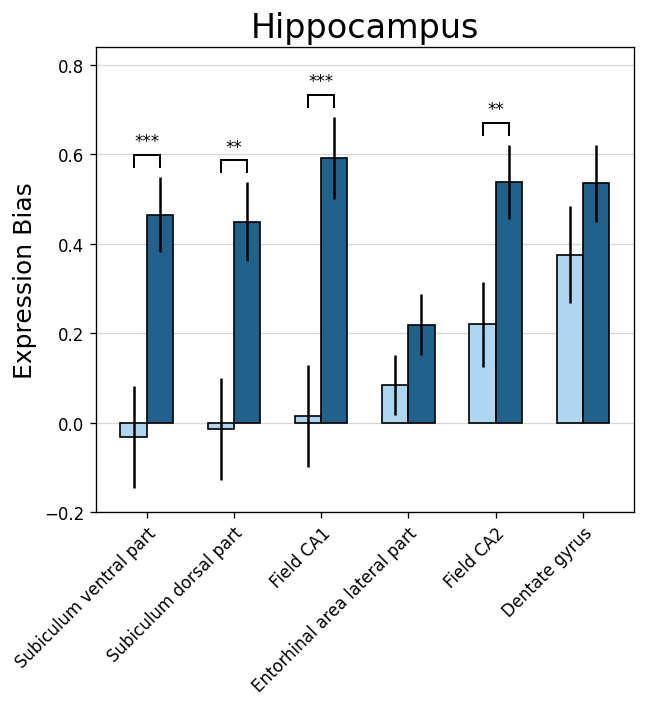

(5, 6)


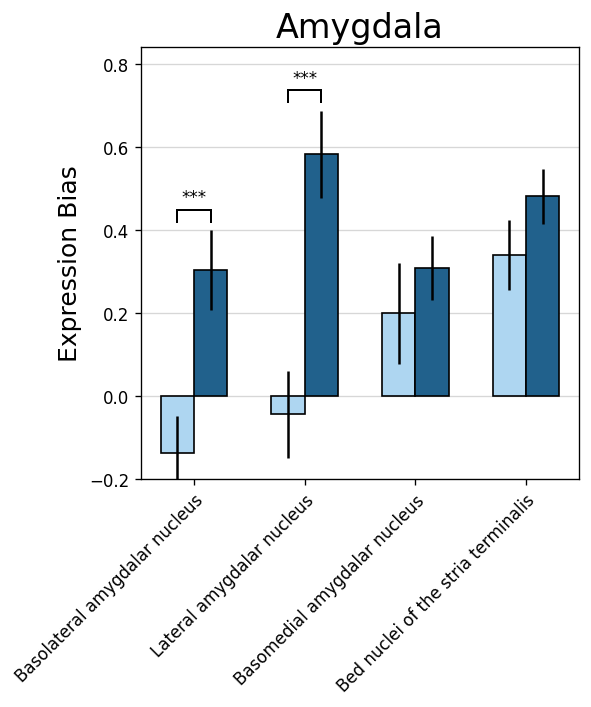

(3, 6)


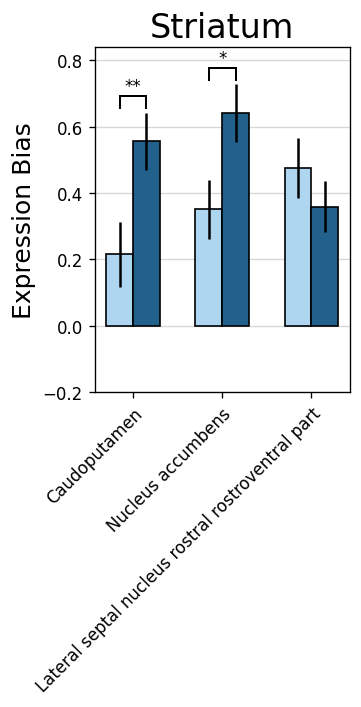

(6, 6)


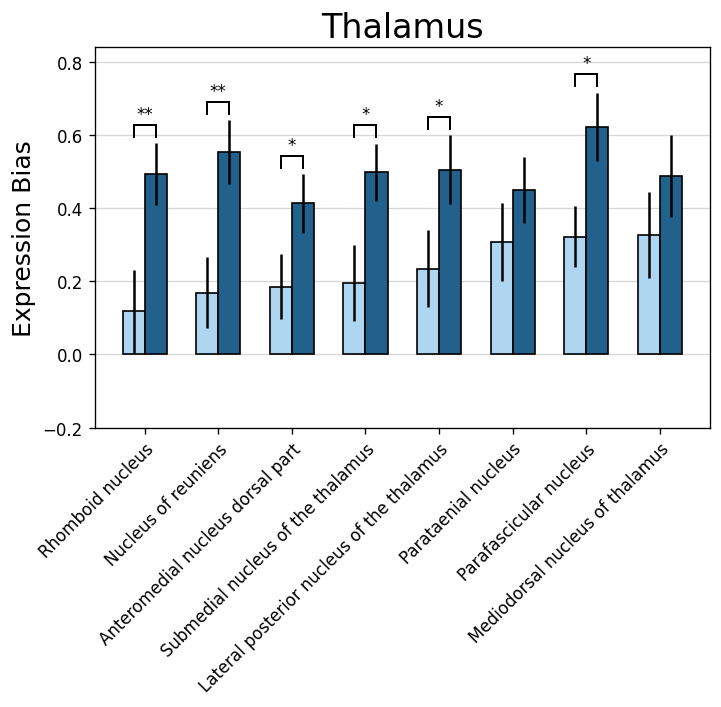

(3, 6)


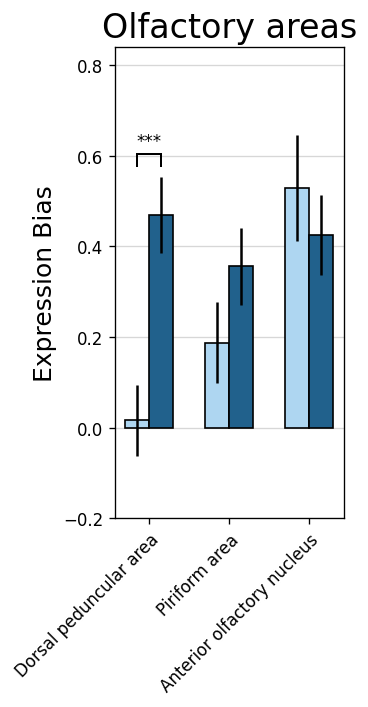

<Figure size 432x288 with 0 Axes>

In [37]:
plt.figure(dpi=480, figsize=(12, 8))

REG = 'Isocortex'
HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
REG_STRs = HIQ_ALL_dat.index.values
HIQ_ALL_err = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
LIQ_ALL_err = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
PlotPhenotype(HIQ_ALL_dat, HIQ_ALL_err, LIQ_ALL_dat,LIQ_ALL_err, REG, IQ_PhenotypeDF,
              "Higher IQ Bias", "Lower IQ Bias", fig_size=(12,6))

REG = 'Hippocampus'
HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
REG_STRs = HIQ_ALL_dat.index.values
HIQ_ALL_err = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
LIQ_ALL_err = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
PlotPhenotype(HIQ_ALL_dat, HIQ_ALL_err, LIQ_ALL_dat,LIQ_ALL_err, REG, IQ_PhenotypeDF,
              "Higher IQ Bias", "Lower IQ Bias",
                 fig_size=(5.5,6))

REG = 'Amygdala'
HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
REG_STRs = HIQ_ALL_dat.index.values
HIQ_ALL_err = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
LIQ_ALL_err = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
PlotPhenotype(HIQ_ALL_dat, HIQ_ALL_err, LIQ_ALL_dat,LIQ_ALL_err, REG, IQ_PhenotypeDF,
              "Higher IQ Bias", "Lower IQ Bias", fig_size=(5,6))

REG = 'Striatum'
HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
REG_STRs = HIQ_ALL_dat.index.values
HIQ_ALL_err = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
LIQ_ALL_err = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
PlotPhenotype(HIQ_ALL_dat, HIQ_ALL_err, LIQ_ALL_dat,LIQ_ALL_err, REG, IQ_PhenotypeDF,
              "Higher IQ Bias", "Lower IQ Bias",fig_size=(3,6))

REG = 'Thalamus'
HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
REG_STRs = HIQ_ALL_dat.index.values
HIQ_ALL_err = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
LIQ_ALL_err = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
PlotPhenotype(HIQ_ALL_dat, HIQ_ALL_err, LIQ_ALL_dat,LIQ_ALL_err, REG, IQ_PhenotypeDF,
              "Higher IQ Bias", "Lower IQ Bias", fig_size=(6,6))

REG = 'Olfactory_areas'
HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
REG_STRs = HIQ_ALL_dat.index.values
HIQ_ALL_err = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
LIQ_ALL_err = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
PlotPhenotype(HIQ_ALL_dat, HIQ_ALL_err, LIQ_ALL_dat,LIQ_ALL_err, REG, IQ_PhenotypeDF,
              "Higher IQ Bias", "Lower IQ Bias", fig_size=(3,6))

plt.tight_layout()

/tmp/ipykernel_3021572/3062081841.py:131: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  hatched_patch = plt.Rectangle((0, 0), 1, 1, facecolor='gray', hatch='/ / /', edgecolor='black')


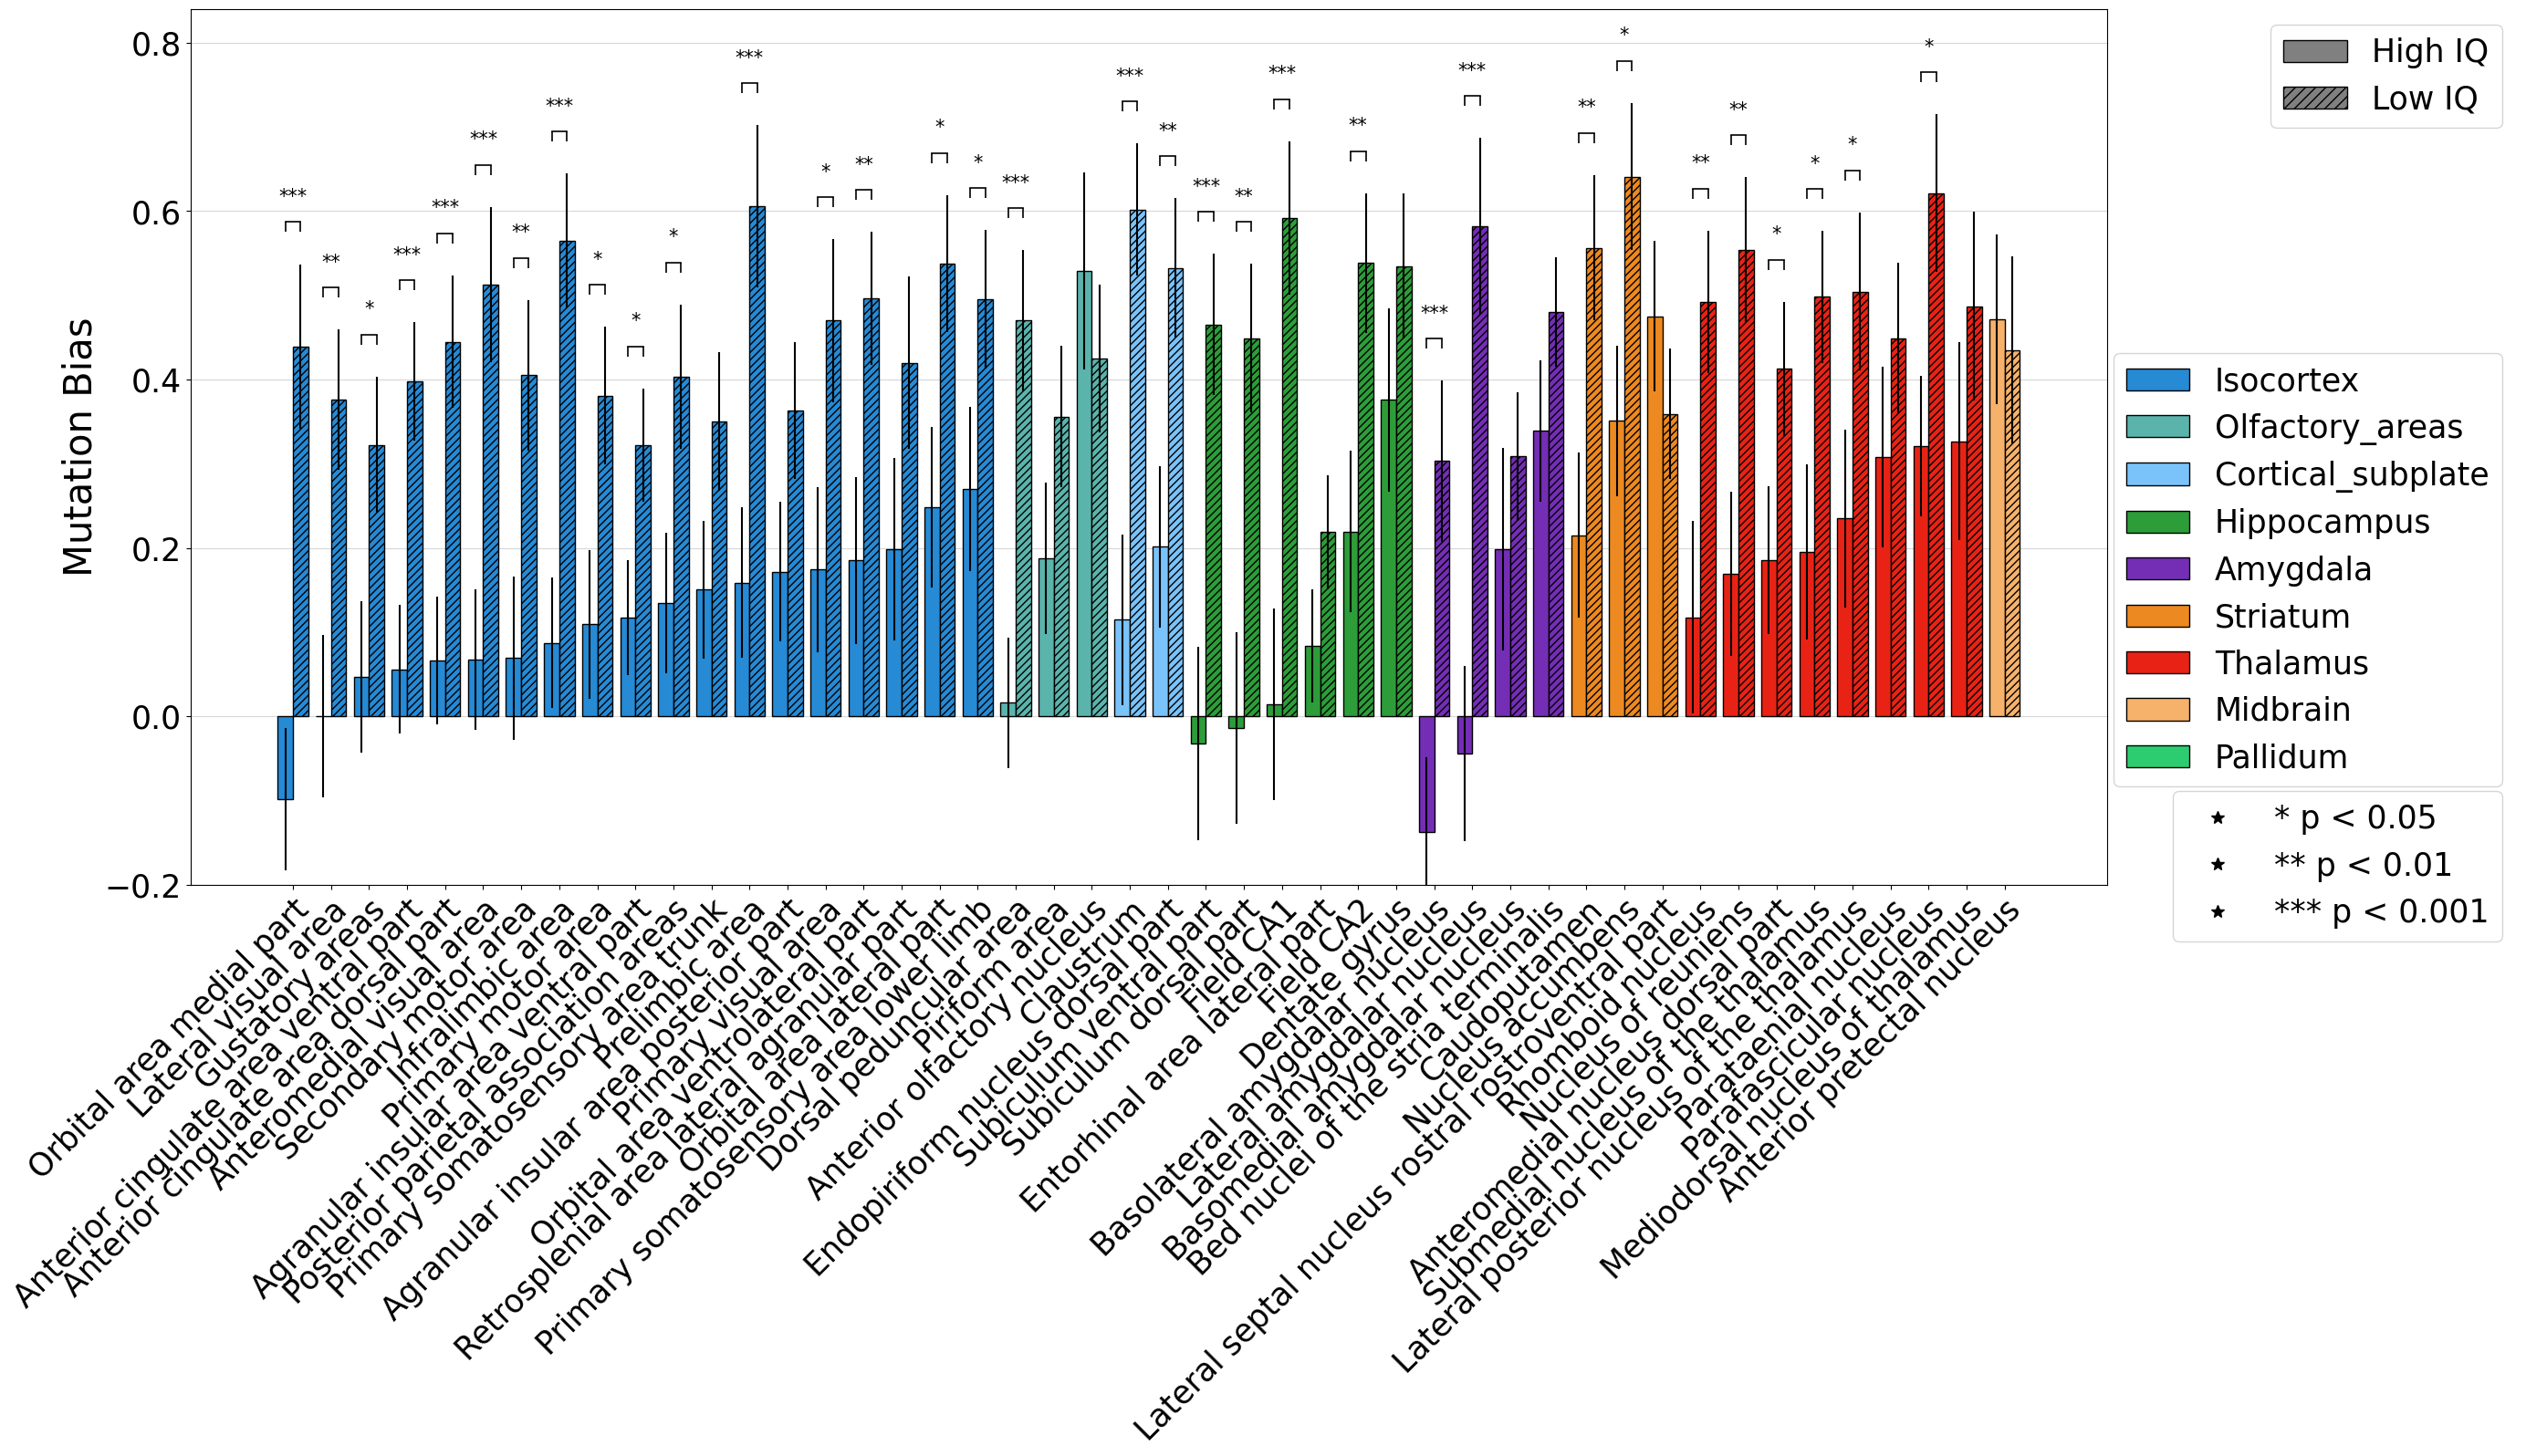

In [31]:
def PlotPhenotype(Dat1, Err1, Dat2, Err2, REG, IQ_PhenotypeDF, x_offset, label1="", label2="", fig_size=0, color=None, ax=None):
    #sort_idx = np.argsort(HighIQ_dat)
    Pvalues = IQ_PhenotypeDF.loc[Dat1.index.values, "Pvalue"].values
    sort_idx = np.argsort(Dat1["EFFECT"].values)
    X = np.arange(Dat1.shape[0])
    if fig_size == 0:
        fig_size = (2.5 + 0.4 * Dat1.shape[0], 6)
    
    # Use provided ax if given, otherwise create new figure
    if ax is None:
        fig, ax = plt.subplots(dpi=120, figsize=fig_size)
    
    dat1 = Dat1["EFFECT"].values[sort_idx]
    err1 = Err1[sort_idx]
    dat2 = Dat2["EFFECT"].values[sort_idx]
    err2 = Err2[sort_idx]
    
    bar_width = 0.4
    
    # Use provided color if specified, otherwise use default colors
    color1 = color if color else "#AED6F1"
    color2 = color if color else "#21618C"
    
    # Calculate x positions based on region index
    region_idx = list(region_colors.keys()).index(REG)
    
    # High IQ bars (left) - solid fill
    ax.bar(X + x_offset - 0.2, dat1, yerr=err1, 
           color=color if color else color1, 
           width=0.4, 
           edgecolor='black')
    
    # Low IQ bars (right) - hatched pattern
    ax.bar(X + x_offset + 0.2, dat2, yerr=err2, 
           color=color if color else color2,
           width=0.4, 
           edgecolor='black',
           hatch='////')  # Add diagonal hatching
    
    Pvalues = Pvalues[sort_idx]
    offset = 0.05
    for i,p in enumerate(Pvalues):
        if p>=0.05:
            continue
        elif p<0.001:
            displaystring = r'***'
        elif p<0.01:
            displaystring = r'**'
        else:
            displaystring = r'*'

        height = offset + max(dat1[i] + err1[i], dat2[i]+err2[i])
        bar_centers = (X[i] + x_offset - 0.4) + np.array([0.5,1.5])*bar_width
        significance_bar(bar_centers[0],bar_centers[1],height,displaystring)
    
    ax.set_xlabel('', fontweight='bold', fontsize=15)
    ax.set_ylabel('Mutation Bias', fontsize=30)
    
    # Add region labels
    labels = drop_fromList(Dat1.index.values[sort_idx])
    ax.set_xticks(X + x_offset)
    ax.set_xticklabels(labels, rotation=45, fontsize=10, ha='right', rotation_mode="anchor")

    # Only add title for individual plots
    if ax is None:
        plt.title(" ".join(REG.split("_")), fontsize=20)
        plt.tight_layout()
        
    ax.set_ylim(-0.2, 0.84)
    ax.grid(True, axis="y", alpha=0.5)
    ax.set_axisbelow(True)
    
    # Increase ytick font size
    ax.tick_params(axis='y', labelsize=25)
    
    # Only show plot immediately for individual plots
    if ax is None:
        plt.show()

# Create figure and axis for combined plot
fig = plt.figure(dpi=100, figsize=(30, 12))
# Create main axis with adjusted position to make room for legends
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])  # [left, bottom, width, height]

# Define colors for each region
region_colors = {'Isocortex': '#268ad5',
'Olfactory_areas': '#5ab4ac',
'Cortical_subplate': '#7ac3fa',
'Hippocampus': '#2c9d39',
'Amygdala': '#742eb5',
'Striatum': '#ed8921',
'Thalamus': '#e82315',
'Midbrain': '#f6b26b',
'Pallidum': '#2ECC71',}

# Create one combined plot
x_offset = 0
all_ticks = []
all_positions = []

for REG in region_colors.keys():
    HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
    LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
    REG_STRs = HIQ_ALL_dat.index.values
    HIQ_ALL_err = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
    LIQ_ALL_err = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
    
    # Store tick positions and labels
    X = np.arange(len(REG_STRs))
    all_positions.extend(X + x_offset)
    all_ticks.extend(drop_fromList(HIQ_ALL_dat.index.values[np.argsort(HIQ_ALL_dat["EFFECT"].values)]))
    
    # Pass ax to PlotPhenotype
    PlotPhenotype(HIQ_ALL_dat, HIQ_ALL_err, LIQ_ALL_dat, LIQ_ALL_err, REG, IQ_PhenotypeDF,
                  x_offset,
                  "Higher IQ Bias", "Lower IQ Bias", 
                  color=region_colors[REG],
                  fig_size=(30,8),
                  ax=ax)
    x_offset += len(REG_STRs)

# Set all tick positions and labels at once
ax.set_xticks(all_positions)
ax.set_xticklabels(all_ticks, rotation=45, ha='right', rotation_mode="anchor", fontsize=25)
ax.tick_params(axis='y', labelsize=25)

# Create legend for IQ groups
legend_ax1 = fig.add_axes([0.85, 0.7, 0.1, 0.2])  # Position for first legend
legend_ax1.axis('off')
solid_patch = plt.Rectangle((0, 0), 1, 1, facecolor='gray', edgecolor='black')
hatched_patch = plt.Rectangle((0, 0), 1, 1, facecolor='gray', hatch='/ / /', edgecolor='black')
legend_ax1.legend([solid_patch, hatched_patch], ['High IQ', 'Low IQ'], fontsize=25)

# Create legend for regions
legend_ax2 = fig.add_axes([0.85, 0.3, 0.1, 0.3])  # Position for second legend
legend_ax2.axis('off')
region_handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') 
                 for color in region_colors.values()]
legend_ax2.legend(region_handles, region_colors.keys(), fontsize=25)

# Create legend for p-values
legend_ax3 = fig.add_axes([0.85, 0.1, 0.1, 0.1])  # Position for third legend
legend_ax3.axis('off')
star1 = plt.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
star2 = plt.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
star3 = plt.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
legend_ax3.legend([star1, star2, star3], ['* p < 0.05', '** p < 0.01', '*** p < 0.001'], fontsize=25)

plt.show()

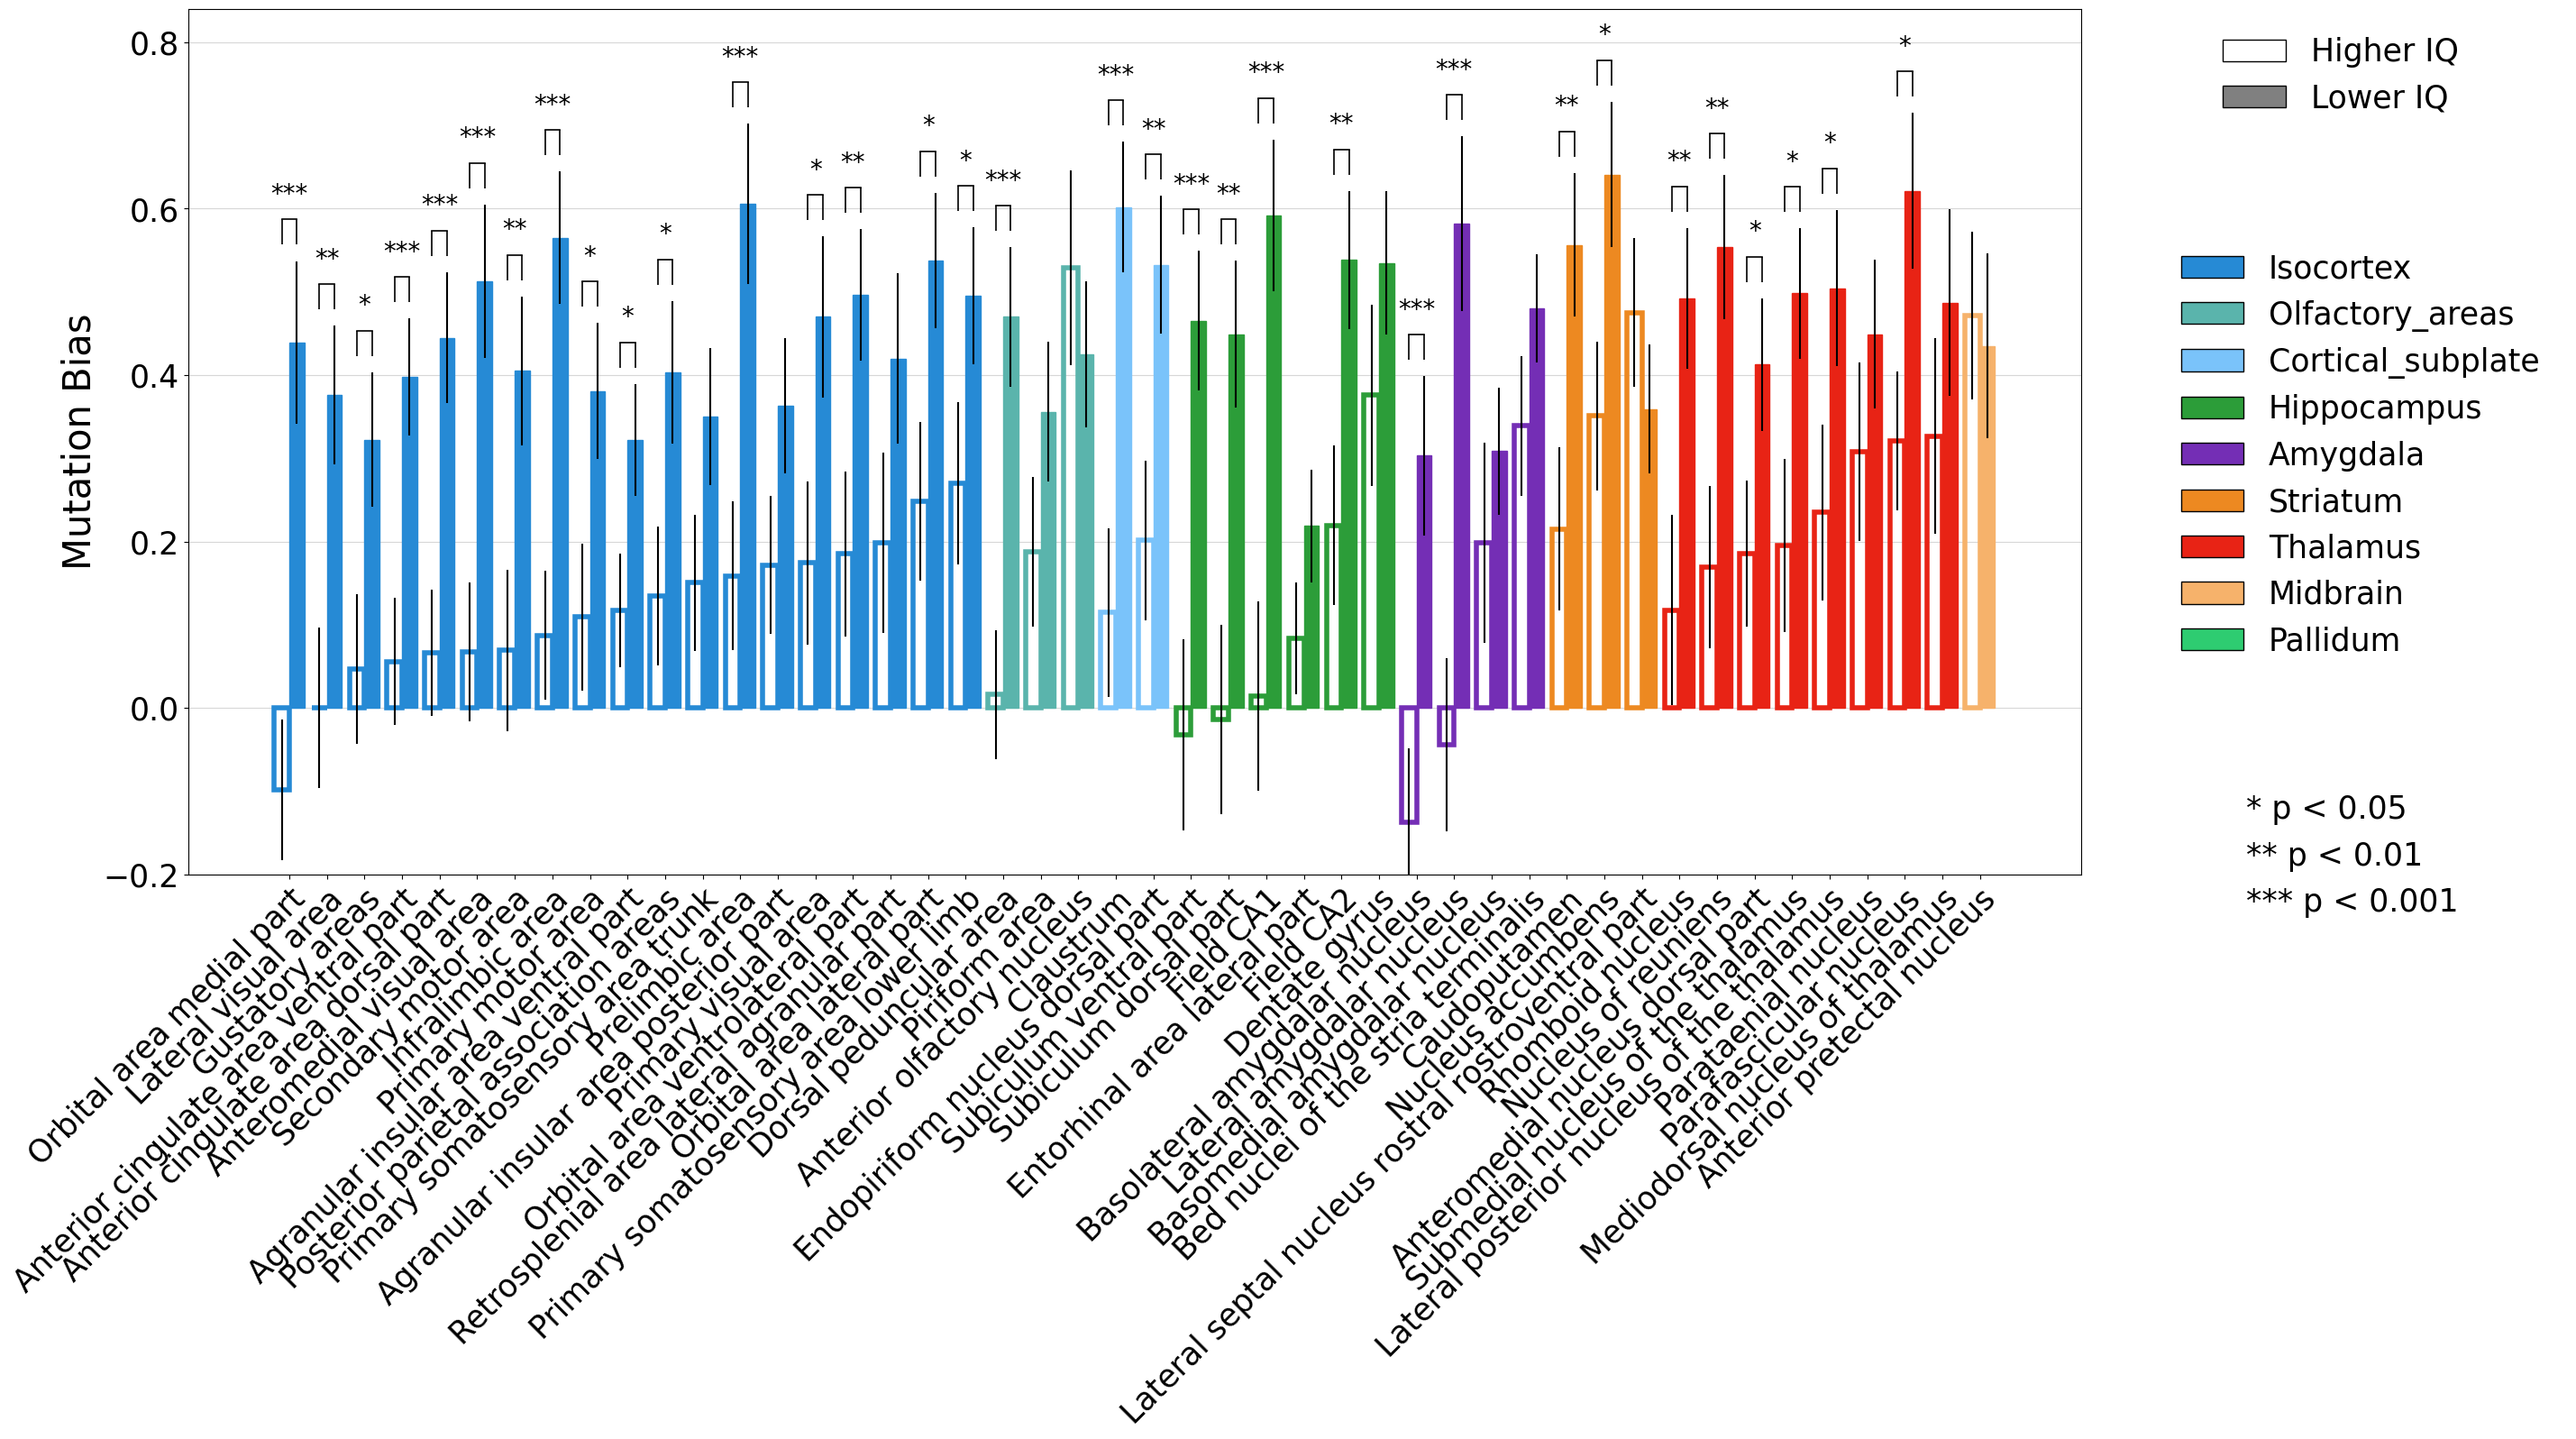

In [32]:
def significance_bar(start,end,height,displaystring,linewidth = 1.2,
                     markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth, marker = TICKDOWN,
             markeredgewidth=linewidth, markersize = markersize)
    
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height + 0.03, displaystring, ha = 'center',va='center', fontsize=fontsize)
             #bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)

def PlotPhenotype(Dat1, Err1, Dat2, Err2, REG, IQ_PhenotypeDF, x_offset, label1="", label2="", fig_size=0, color=None, ax=None):
    #sort_idx = np.argsort(HighIQ_dat)
    Pvalues = IQ_PhenotypeDF.loc[Dat1.index.values, "Pvalue"].values
    sort_idx = np.argsort(Dat1["EFFECT"].values)
    X = np.arange(Dat1.shape[0])
    if fig_size == 0:
        fig_size = (2.5 + 0.4 * Dat1.shape[0], 6)
    
    # Use provided ax if given, otherwise create new figure
    if ax is None:
        fig, ax = plt.subplots(dpi=120, figsize=fig_size)
    
    dat1 = Dat1["EFFECT"].values[sort_idx]
    err1 = Err1[sort_idx]
    dat2 = Dat2["EFFECT"].values[sort_idx]
    err2 = Err2[sort_idx]
    
    bar_width = 0.4
    
    # Use provided color if specified, otherwise use default colors
    color1 = color if color else "#AED6F1"
    color2 = color if color else "#21618C"
    
    # Calculate x positions based on region index
    region_idx = list(region_colors.keys()).index(REG)
    
    # High IQ bars (left) - solid fill
    # High IQ bars (left) - filled
    ax.bar(X + x_offset - 0.2, dat1, yerr=err1,
           color='none',  # Transparent fill
           width=0.4,
           edgecolor=color if color else color2,
           linewidth=4)
    
    # Low IQ bars (right) - open/unfilled
    ax.bar(X + x_offset + 0.2, dat2, yerr=err2,
           color=color,  # 
           width=0.4,
           edgecolor=color if color else color2,
           linewidth=1)  # Make edge more visible since bar is unfilled
    
    Pvalues = Pvalues[sort_idx]
    offset = 0.05
    for i,p in enumerate(Pvalues):
        if p>=0.05:
            continue
        elif p<0.001:
            displaystring = r'***'
        elif p<0.01:
            displaystring = r'**'
        else:
            displaystring = r'*'

        height = offset + max(dat1[i] + err1[i], dat2[i]+err2[i])
        bar_centers = (X[i] + x_offset - 0.4) + np.array([0.5,1.5])*bar_width
        significance_bar(bar_centers[0],bar_centers[1],height,displaystring, markersize=20, fontsize=20)
    
    ax.set_xlabel('', fontweight='bold', fontsize=15)
    ax.set_ylabel('Mutation Bias', fontsize=30)
    
    # Add region labels
    labels = drop_fromList(Dat1.index.values[sort_idx])
    ax.set_xticks(X + x_offset)
    ax.set_xticklabels(labels, rotation=45, fontsize=10, ha='right', rotation_mode="anchor")

    # Only add title for individual plots
    if ax is None:
        plt.title(" ".join(REG.split("_")), fontsize=20)
        plt.tight_layout()
        
    ax.set_ylim(-0.2, 0.84)
    ax.grid(True, axis="y", alpha=0.5)
    ax.set_axisbelow(True)
    
    # Increase ytick font size
    ax.tick_params(axis='y', labelsize=25)
    
    # Only show plot immediately for individual plots
    if ax is None:
        plt.show()

# Create figure and axis for combined plot
fig = plt.figure(dpi=100, figsize=(30, 12))
# Create main axis with adjusted position to make room for legends
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])  # [left, bottom, width, height]

# Define colors for each region
region_colors = {'Isocortex': '#268ad5',
'Olfactory_areas': '#5ab4ac',
'Cortical_subplate': '#7ac3fa',
'Hippocampus': '#2c9d39',
'Amygdala': '#742eb5',
'Striatum': '#ed8921',
'Thalamus': '#e82315',
'Midbrain': '#f6b26b',
'Pallidum': '#2ECC71',}

# Create one combined plot
x_offset = 0
all_ticks = []
all_positions = []

for REG in region_colors.keys():
    HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
    LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
    REG_STRs = HIQ_ALL_dat.index.values
    HIQ_ALL_err = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
    LIQ_ALL_err = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
    
    # Store tick positions and labels
    X = np.arange(len(REG_STRs))
    all_positions.extend(X + x_offset)
    all_ticks.extend(drop_fromList(HIQ_ALL_dat.index.values[np.argsort(HIQ_ALL_dat["EFFECT"].values)]))
    
    # Pass ax to PlotPhenotype
    PlotPhenotype(HIQ_ALL_dat, HIQ_ALL_err, LIQ_ALL_dat, LIQ_ALL_err, REG, IQ_PhenotypeDF,
                  x_offset,
                  "Higher IQ Bias", "Lower IQ Bias", 
                  color=region_colors[REG],
                  fig_size=(30,8),
                  ax=ax)
    x_offset += len(REG_STRs)

# Set all tick positions and labels at once
ax.set_xticks(all_positions)
ax.set_xticklabels(all_ticks, rotation=45, ha='right', rotation_mode="anchor", fontsize=25)
ax.tick_params(axis='y', labelsize=25)

# Create legend for IQ groups
legend_ax1 = fig.add_axes([0.85, 0.7, 0.1, 0.2])  # Position for first legend
legend_ax1.axis('off')
filled_patch = plt.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='black')
open_patch_patch = plt.Rectangle((0, 0), 1, 1, facecolor='gray', edgecolor='black')
legend_ax1.legend([filled_patch, open_patch_patch], ['Higher IQ', 'Lower IQ'], fontsize=25, frameon=False)

# Create legend for regions
legend_ax2 = fig.add_axes([0.88, 0.4, 0.1, 0.3])  # Position for second legend
legend_ax2.axis('off')
region_handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') 
                 for color in region_colors.values()]
legend_ax2.legend(region_handles, region_colors.keys(), fontsize=25, frameon=False)

# Create legend for p-values
legend_ax3 = fig.add_axes([0.85, 0.1, 0.1, 0.1])  # Position for third legend
legend_ax3.axis('off')
star1 = plt.Line2D([], [], color='black', marker='', linestyle='None', markersize=10)
star2 = plt.Line2D([], [], color='black', marker='', linestyle='None', markersize=10)
star3 = plt.Line2D([], [], color='black', marker='', linestyle='None', markersize=10)
legend_ax3.legend([star1, star2, star3], ['* p < 0.05', '** p < 0.01', '*** p < 0.001'], fontsize=25, frameon=False)

plt.show()

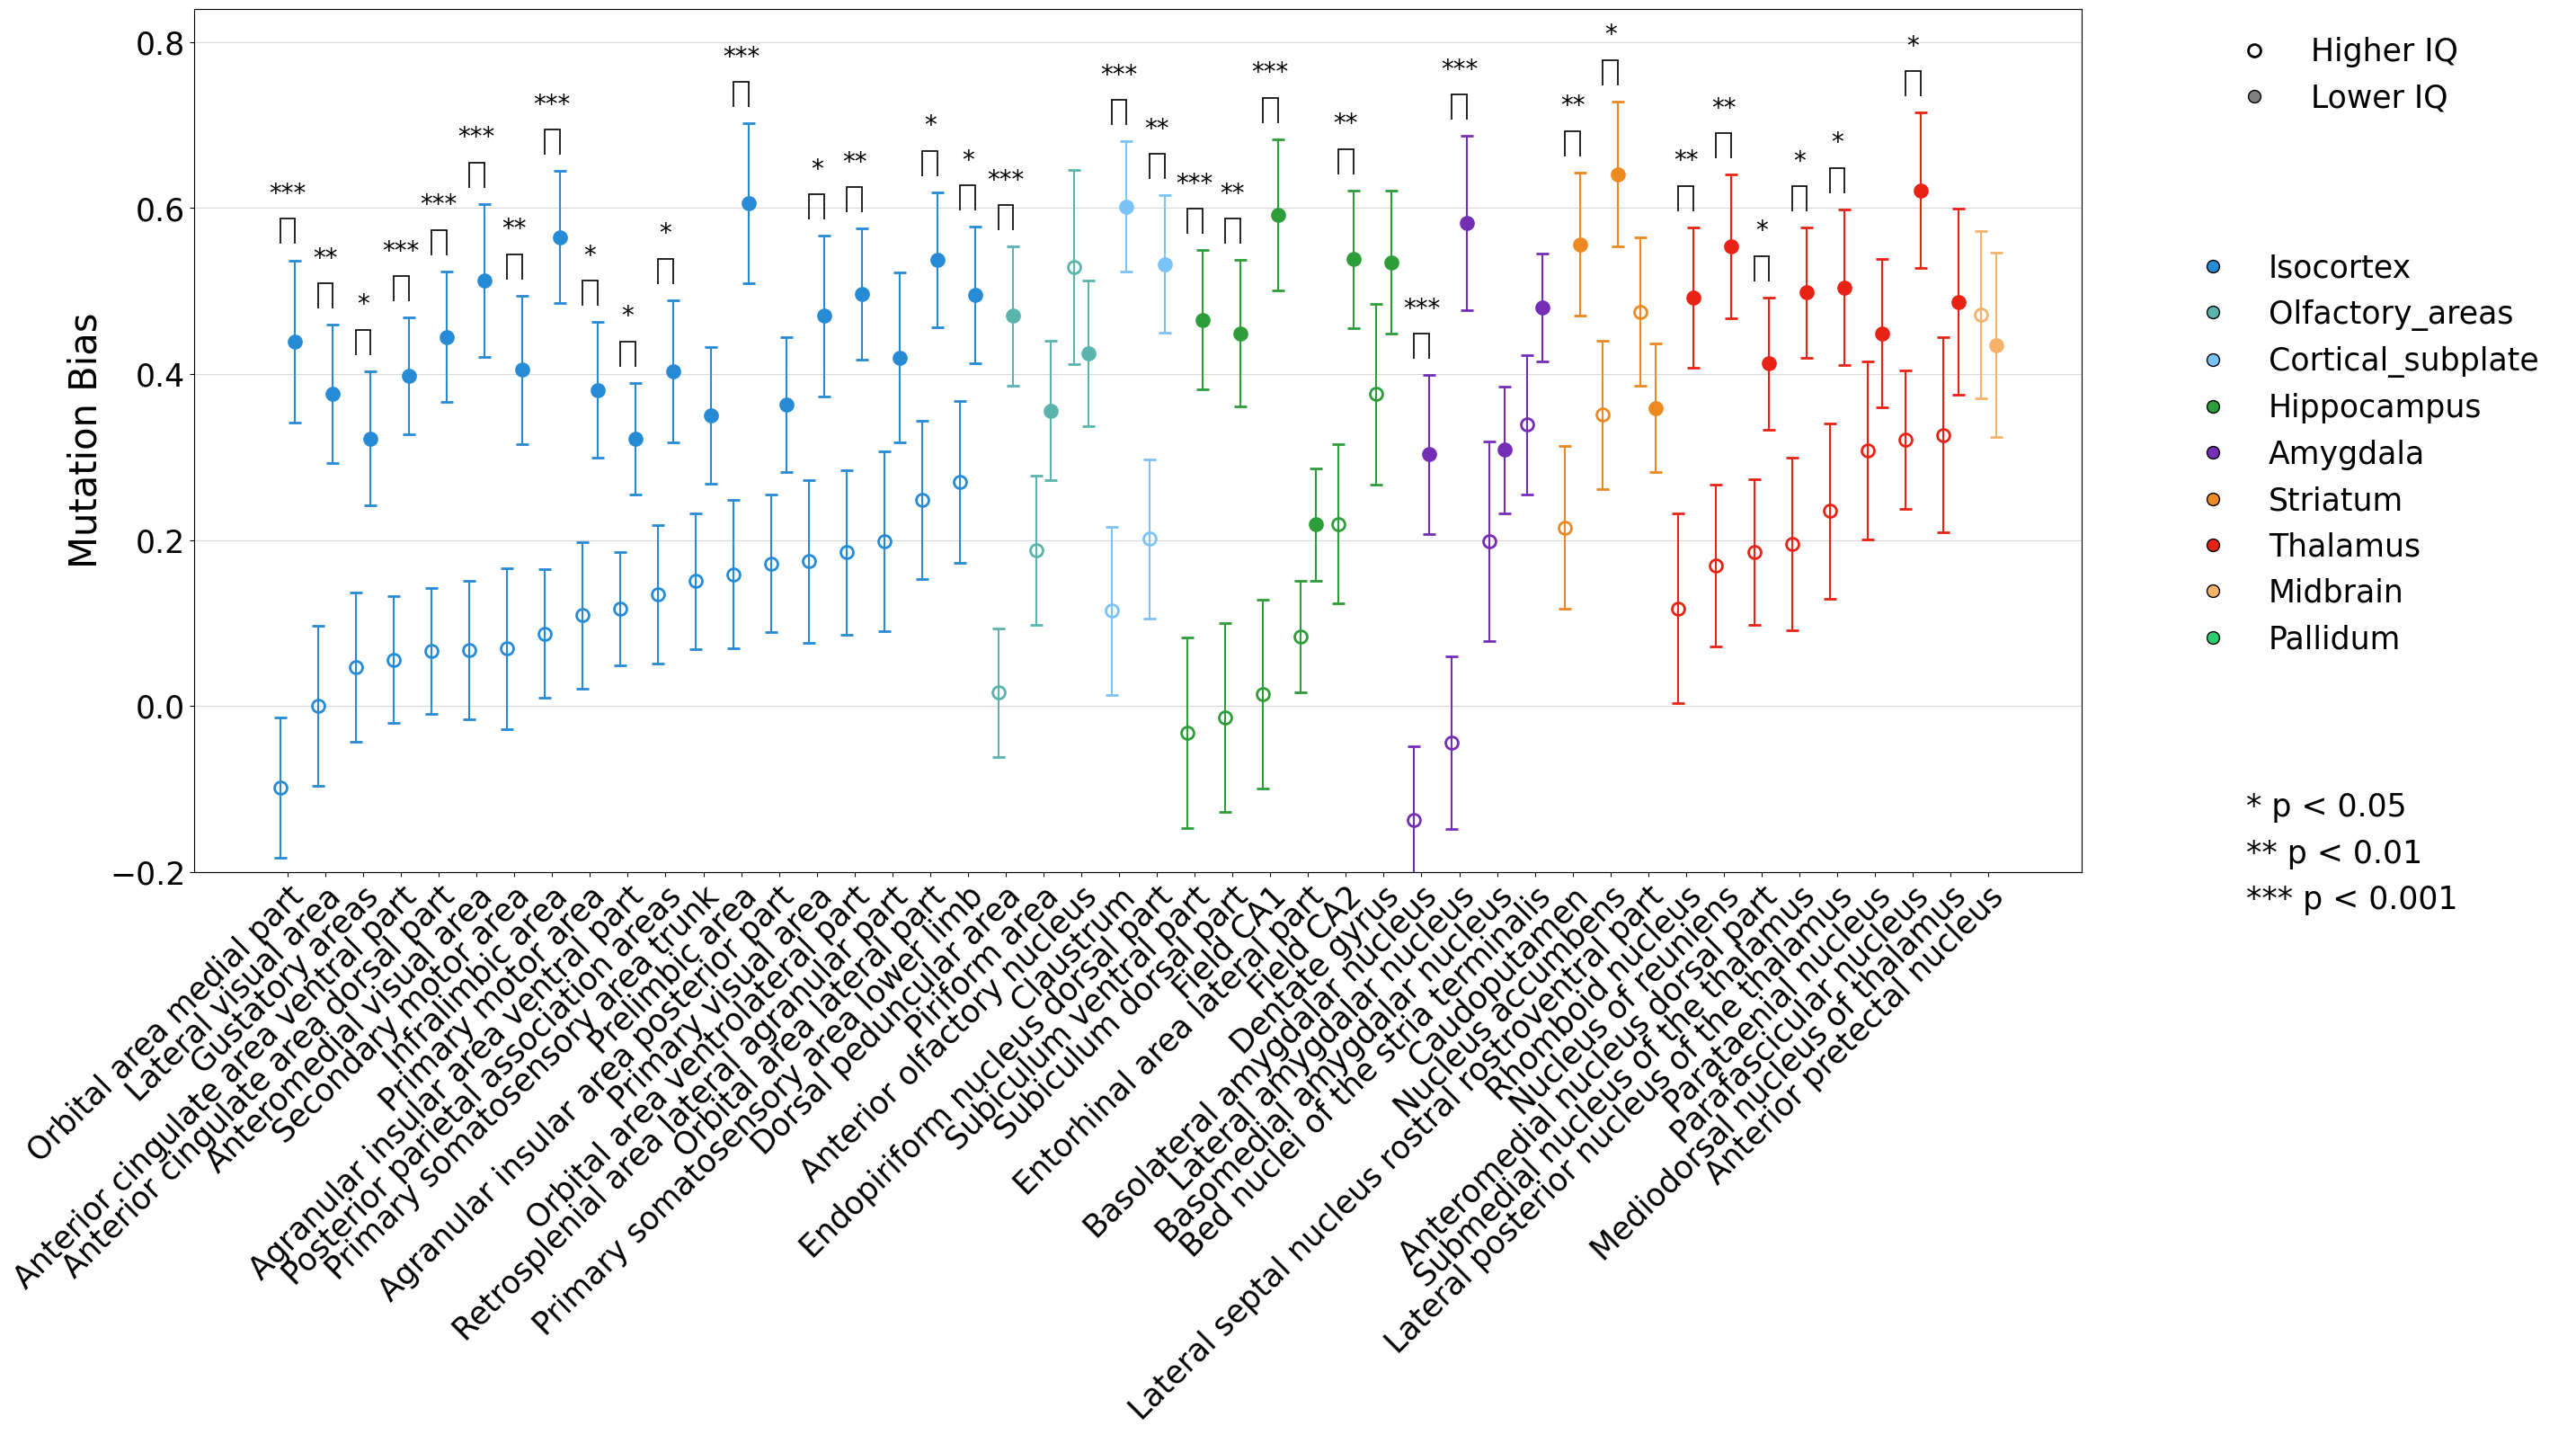

In [33]:
def significance_bar(start,end,height,displaystring,linewidth = 1.2,
                     markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth, marker = TICKDOWN,
             markeredgewidth=linewidth, markersize = markersize)
    
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height + 0.03, displaystring, ha = 'center',va='center', fontsize=fontsize)
             #bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)

def PlotPhenotype(Dat1, Err1, Dat2, Err2, REG, IQ_PhenotypeDF, x_offset, label1="", label2="", fig_size=0, color=None, ax=None):
    Pvalues = IQ_PhenotypeDF.loc[Dat1.index.values, "Pvalue"].values
    sort_idx = np.argsort(Dat1["EFFECT"].values)
    X = np.arange(Dat1.shape[0])
    if fig_size == 0:
        fig_size = (2.5 + 0.4 * Dat1.shape[0], 6)
    
    # Use provided ax if given, otherwise create new figure
    if ax is None:
        fig, ax = plt.subplots(dpi=120, figsize=fig_size)
    
    dat1 = Dat1["EFFECT"].values[sort_idx]
    err1 = Err1[sort_idx]
    dat2 = Dat2["EFFECT"].values[sort_idx]
    err2 = Err2[sort_idx]
    
    # Use provided color if specified, otherwise use default colors
    color1 = color if color else "#AED6F1"
    color2 = color if color else "#21618C"
    
    # Plot dots instead of bars
    # High IQ dots (left)
    ax.errorbar(X + x_offset - 0.2, dat1, yerr=err1,
                fmt='o', markersize=10, color='none',
                markeredgecolor=color if color else color2,
                markeredgewidth=2,
                ecolor=color if color else color2,
                capsize=5)
    
    # Low IQ dots (right)
    ax.errorbar(X + x_offset + 0.2, dat2, yerr=err2,
                fmt='o', markersize=10, color=color,
                markeredgecolor=color if color else color2,
                markeredgewidth=2,
                ecolor=color if color else color2,
                capsize=5)
    
    Pvalues = Pvalues[sort_idx]
    offset = 0.05
    for i,p in enumerate(Pvalues):
        if p>=0.05:
            continue
        elif p<0.001:
            displaystring = r'***'
        elif p<0.01:
            displaystring = r'**'
        else:
            displaystring = r'*'

        height = offset + max(dat1[i] + err1[i], dat2[i]+err2[i])
        dot_centers = (X[i] + x_offset - 0.2, X[i] + x_offset + 0.2)
        significance_bar(dot_centers[0], dot_centers[1], height, displaystring, markersize=20, fontsize=20)
    
    ax.set_xlabel('', fontweight='bold', fontsize=15)
    ax.set_ylabel('Mutation Bias', fontsize=30)
    
    # Add region labels
    labels = drop_fromList(Dat1.index.values[sort_idx])
    ax.set_xticks(X + x_offset)
    ax.set_xticklabels(labels, rotation=45, fontsize=10, ha='right', rotation_mode="anchor")

    # Only add title for individual plots
    if ax is None:
        plt.title(" ".join(REG.split("_")), fontsize=20)
        plt.tight_layout()
        
    ax.set_ylim(-0.2, 0.84)
    ax.grid(True, axis="y", alpha=0.5)
    ax.set_axisbelow(True)
    
    # Increase ytick font size
    ax.tick_params(axis='y', labelsize=25)
    
    # Only show plot immediately for individual plots
    if ax is None:
        plt.show()

# Create figure and axis for combined plot
fig = plt.figure(dpi=100, figsize=(30, 12))
# Create main axis with adjusted position to make room for legends
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])  # [left, bottom, width, height]

# Define colors for each region
region_colors = {'Isocortex': '#268ad5',
'Olfactory_areas': '#5ab4ac',
'Cortical_subplate': '#7ac3fa',
'Hippocampus': '#2c9d39',
'Amygdala': '#742eb5',
'Striatum': '#ed8921',
'Thalamus': '#e82315',
'Midbrain': '#f6b26b',
'Pallidum': '#2ECC71',}

# Create one combined plot
x_offset = 0
all_ticks = []
all_positions = []

for REG in region_colors.keys():
    HIQ_ALL_dat = HIQ_Cir[HIQ_Cir["REGION"]==REG]
    LIQ_ALL_dat = LIQ_Cir[LIQ_Cir["REGION"]==REG]
    REG_STRs = HIQ_ALL_dat.index.values
    HIQ_ALL_err = np.array([np.std(GetBootsDist_STR(HIQ_BootDFs, STR)) for STR in REG_STRs])
    LIQ_ALL_err = np.array([np.std(GetBootsDist_STR(LIQ_BootDFs, STR)) for STR in REG_STRs])
    
    # Store tick positions and labels
    X = np.arange(len(REG_STRs))
    all_positions.extend(X + x_offset)
    all_ticks.extend(drop_fromList(HIQ_ALL_dat.index.values[np.argsort(HIQ_ALL_dat["EFFECT"].values)]))
    
    # Pass ax to PlotPhenotype
    PlotPhenotype(HIQ_ALL_dat, HIQ_ALL_err, LIQ_ALL_dat, LIQ_ALL_err, REG, IQ_PhenotypeDF,
                  x_offset,
                  "Higher IQ Bias", "Lower IQ Bias", 
                  color=region_colors[REG],
                  fig_size=(30,8),
                  ax=ax)
    x_offset += len(REG_STRs)

# Set all tick positions and labels at once
ax.set_xticks(all_positions)
ax.set_xticklabels(all_ticks, rotation=45, ha='right', rotation_mode="anchor", fontsize=25)
ax.tick_params(axis='y', labelsize=25)

# Create legend for IQ groups
legend_ax1 = fig.add_axes([0.85, 0.7, 0.1, 0.2])  # Position for first legend
legend_ax1.axis('off')
filled_dot = plt.Line2D([0], [0], marker='o', color='none', markerfacecolor='none', 
                       markeredgecolor='black', markersize=10, markeredgewidth=2)
open_dot = plt.Line2D([0], [0], marker='o', color='none', markerfacecolor='gray',
                      markeredgecolor='black', markersize=10)
legend_ax1.legend([filled_dot, open_dot], ['Higher IQ', 'Lower IQ'], fontsize=25, frameon=False)

# Create legend for regions
legend_ax2 = fig.add_axes([0.88, 0.4, 0.1, 0.3])  # Position for second legend
legend_ax2.axis('off')
region_handles = [plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=color,
                            markeredgecolor='black', markersize=10)
                 for color in region_colors.values()]
legend_ax2.legend(region_handles, region_colors.keys(), fontsize=25, frameon=False)

# Create legend for p-values
legend_ax3 = fig.add_axes([0.85, 0.1, 0.1, 0.1])  # Position for third legend
legend_ax3.axis('off')
star1 = plt.Line2D([], [], color='black', marker='', linestyle='None', markersize=10)
star2 = plt.Line2D([], [], color='black', marker='', linestyle='None', markersize=10)
star3 = plt.Line2D([], [], color='black', marker='', linestyle='None', markersize=10)
legend_ax3.legend([star1, star2, star3], ['* p < 0.05', '** p < 0.01', '*** p < 0.001'], fontsize=25, frameon=False)

plt.show()

# Sex

In [151]:
ASC_IQ_dat = pd.read_excel("../doc/1-s2.0-S0092867419313984-mmc4.xlsx", sheet_name="Phenotype")
ASC_IQ_dat = ASC_IQ_dat[ASC_IQ_dat["Role"]=="Proband"]
ASC_IQ_dat = ASC_IQ_dat.dropna(subset=['IQ'])
ASC_Male = ASC_IQ_dat[ASC_IQ_dat["Sex"]=="Male"]["Phenotype_ID"].values
ASC_Female = ASC_IQ_dat[ASC_IQ_dat["Sex"]=="Female"]["Phenotype_ID"].values

Spark_IQ_dat = pd.read_csv("../../ASD_Phenotype/SPARK_Collection_Version6/core_descriptive_variables.csv")
Spark_IQ_dat = Spark_IQ_dat[Spark_IQ_dat["asd"]==True]
Spark_IQ_dat = Spark_IQ_dat.dropna(subset=['fsiq'])
Spark_Male = Spark_IQ_dat[Spark_IQ_dat["sex"]=="Male"]["subject_sp_id"].values
Spark_Female = Spark_IQ_dat[Spark_IQ_dat["sex"]=="Female"]["subject_sp_id"].values

Male = np.concatenate([ASC_Male, Spark_Male])
Female = np.concatenate([ASC_Female, Spark_Female])

ASD_Discov_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")

ASD_Rep_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Rep_DNVs.txt", delimiter="\t")
ASD_Rep_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Rep_Trios.txt", delimiter="\t")

ASD_Muts = pd.concat([ASD_Discov_Muts, ASD_Rep_Muts])
ASD_Trios = pd.concat([ASD_Discov_Trios, ASD_Rep_Trios])

Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_HC = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]
#Spark_Meta_HC = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1e-03]
HighConfGenes = Spark_Meta_HC["HGNC"].values
HighConfMuts = ASD_Muts[ASD_Muts["HGNC"].isin(HighConfGenes)]
HighConfMuts = Filt_LGD_Mis(HighConfMuts, Dmis=True)

Male_Muts = HighConfMuts[HighConfMuts["IID"].isin(Male)]
Female_Muts = HighConfMuts[HighConfMuts["IID"].isin(Female)]

/home/jw3514/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/tmp/ipykernel_9001/1434545554.py:7: DtypeWarning: Columns (19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  Spark_IQ_dat = pd.read_csv("../../ASD_Phenotype/SPARK_Collection_Version6/core_descriptive_variables.csv")


In [152]:
Male_Muts.to_csv("../dat/Unionize_bias/Gender.Male.Highconf.Muts.csv", index=False)
Female_Muts.to_csv("../dat/Unionize_bias/Gender.Female.Highconf.Muts.csv", index=False)

In [153]:
print(Male_Muts.shape, Female_Muts.shape)

(156, 44) (65, 44)


In [154]:
Male_GW = Mut2GeneDF(Male_Muts, LGD=True, Dmis=True) 
Male_GW_LGD = Mut2GeneDF(Male_Muts, LGD=True, Dmis=False) 
Male_GW_Dmis = Mut2GeneDF(Male_Muts, LGD=False, Dmis=True) 
Male_ALL = AvgSTRZ_Weighted(ExpZ2Mat, Male_GW, 
                                 Method = 1, csv_fil = "../dat/Unionize_bias/ASD.Male.ALL.bias.csv")
Male_LGD = AvgSTRZ_Weighted(ExpZ2Mat, Male_GW_LGD, 
                                 Method = 1, csv_fil = "../dat/Unionize_bias/ASD.Male.LGD.bias.csv")
Male_Dmis = AvgSTRZ_Weighted(ExpZ2Mat, Male_GW_Dmis, 
                                 Method = 1, csv_fil = "../dat/Unionize_bias/ASD.Male.Dmis.bias.csv")

Female_GW = Mut2GeneDF(Female_Muts, LGD=True, Dmis=True)
Female_GW_LGD = Mut2GeneDF(Female_Muts, LGD=True, Dmis=False)
Female_GW_Dmis = Mut2GeneDF(Female_Muts, LGD=False, Dmis=True)
Female_ALL = AvgSTRZ_Weighted(ExpZ2Mat, Female_GW, 
                                 Method = 1, csv_fil = "../dat/Unionize_bias/ASD.Female.ALL.bias.csv")
Female_LGD = AvgSTRZ_Weighted(ExpZ2Mat, Female_GW_LGD, 
                                 Method = 1, csv_fil = "../dat/Unionize_bias/ASD.Female.LGD.bias.csv")
Female_Dmis = AvgSTRZ_Weighted(ExpZ2Mat, Female_GW_Dmis, 
                                 Method = 1, csv_fil = "../dat/Unionize_bias/ASD.Female.Dmis.bias.csv")
Male_ALL = Male_ALL.set_index("STR")
Male_LGD = Male_LGD.set_index("STR")
Male_Dmis = Male_Dmis.set_index("STR")
Female_ALL = Female_ALL.set_index("STR")
Female_LGD = Female_LGD.set_index("STR")
Female_Dmis = Female_Dmis.set_index("STR")

In [183]:
Male_ALL_Cir = Male_ALL.loc[ASD_Circuits,:]
Male_LGD_Cir = Male_LGD.loc[ASD_Circuits,:]
Male_Dmis_Cir = Male_Dmis.loc[ASD_Circuits,:]
Female_ALL_Cir = Female_ALL.loc[ASD_Circuits,:]
Female_LGD_Cir = Female_LGD.loc[ASD_Circuits,:]
Female_Dmis_Cir = Female_Dmis.loc[ASD_Circuits,:]


Male_ALL_Cir.loc["Bed_nuclei_of_the_stria_terminalis", "REGION"] = "Amygdalar"
Male_LGD_Cir.loc["Bed_nuclei_of_the_stria_terminalis", "REGION"] = "Amygdalar"
Male_Dmis_Cir.loc["Bed_nuclei_of_the_stria_terminalis", "REGION"] = "Amygdalar"
Female_ALL_Cir.loc["Bed_nuclei_of_the_stria_terminalis", "REGION"] = "Amygdalar"
Female_LGD_Cir.loc["Bed_nuclei_of_the_stria_terminalis", "REGION"] = "Amygdalar"
Female_Dmis_Cir.loc["Bed_nuclei_of_the_stria_terminalis", "REGION"] = "Amygdalar"

In [184]:
Male_BootDFs = []
Male_BootDFs_LGD = []
Male_BootDFs_Dmis = []
for i in range(1,1001,1):
    df1 = pd.read_csv('../dat/Unionize_bias/Bootstrap/ASD.Male/boot.bias.ALL.{}.csv'.format(i), index_col="STR")
    df2 = pd.read_csv('../dat/Unionize_bias/Bootstrap/ASD.Male/boot.bias.LGD.{}.csv'.format(i), index_col="STR")
    df3 = pd.read_csv('../dat/Unionize_bias/Bootstrap/ASD.Male/boot.bias.Dmis.{}.csv'.format(i), index_col="STR")
    Male_BootDFs.append(df1)
    Male_BootDFs_LGD.append(df2)
    Male_BootDFs_Dmis.append(df3)

Female_BootDFs = []
Female_BootDFs_LGD = []
Female_BootDFs_Dmis = []
for i in range(1,1001,1):
    df1 = pd.read_csv('../dat/Unionize_bias/Bootstrap/ASD.Female/boot.bias.ALL.{}.csv'.format(i), index_col="STR")
    df2 = pd.read_csv('../dat/Unionize_bias/Bootstrap/ASD.Female/boot.bias.LGD.{}.csv'.format(i), index_col="STR")
    df3 = pd.read_csv('../dat/Unionize_bias/Bootstrap/ASD.Female/boot.bias.Dmis.{}.csv'.format(i), index_col="STR")
    Female_BootDFs.append(df1)
    Female_BootDFs_LGD.append(df2)
    Female_BootDFs_Dmis.append(df3)

In [186]:
CIR_REGIONS = ['Isocortex', 'Hippocampus', 'Amygdalar', 'Striatum', 'Thalamus', 'Olfactory_areas']
Male_ALL_dat = []
Male_LGD_dat = []
Male_Dmis_dat = []
Female_ALL_dat = []
Female_LGD_dat = []
Female_Dmis_dat = []

Male_err = []
Male_LGD_err = []
Male_Dmis_err = []
Female_err = []
Female_LGD_err = []
Female_Dmis_err = []

for REG in CIR_REGIONS:
    Male_ALL_dat.append(Male_ALL_Cir[Male_ALL_Cir["REGION"]==REG]["EFFECT"].mean())
    Male_LGD_dat.append(Male_LGD_Cir[Male_LGD_Cir["REGION"]==REG]["EFFECT"].mean())
    Male_Dmis_dat.append(Male_Dmis_Cir[Male_Dmis_Cir["REGION"]==REG]["EFFECT"].mean())
    Female_ALL_dat.append(Female_ALL_Cir[Female_ALL_Cir["REGION"]==REG]["EFFECT"].mean())
    Female_LGD_dat.append(Female_LGD_Cir[Female_LGD_Cir["REGION"]==REG]["EFFECT"].mean())
    Female_Dmis_dat.append(Female_Dmis_Cir[Female_Dmis_Cir["REGION"]==REG]["EFFECT"].mean())
    
    Male_err.append(np.std(GetBootsDist(Male_BootDFs, CIR_REGIONS_Dict[REG])))
    Male_LGD_err.append(np.std(GetBootsDist(Male_BootDFs_LGD, CIR_REGIONS_Dict[REG])))
    Male_Dmis_err.append(np.std(GetBootsDist(Male_BootDFs_Dmis, CIR_REGIONS_Dict[REG])))
    Female_err.append(np.std(GetBootsDist(Female_BootDFs, CIR_REGIONS_Dict[REG])))
    Female_LGD_err.append(np.std(GetBootsDist(Female_BootDFs_LGD, CIR_REGIONS_Dict[REG])))
    Female_Dmis_err.append(np.std(GetBootsDist(Female_BootDFs_Dmis, CIR_REGIONS_Dict[REG])))
    
Male_ALL_dat = np.array(Male_ALL_dat)
Male_LGD_dat = np.array(Male_LGD_dat)
Male_Dmis_dat = np.array(Male_Dmis_dat)    
Female_ALL_dat = np.array(Female_ALL_dat)
Female_LGD_dat = np.array(Female_LGD_dat)
Female_Dmis_dat = np.array(Female_Dmis_dat)  
Male_err = np.array(Male_err)
Male_LGD_err = np.array(Male_LGD_err)
Male_Dmis_err = np.array(Male_Dmis_err)
Female_err = np.array(Female_err)
Female_LGD_err = np.array(Female_LGD_err)
Female_Dmis_err = np.array(Female_Dmis_err)

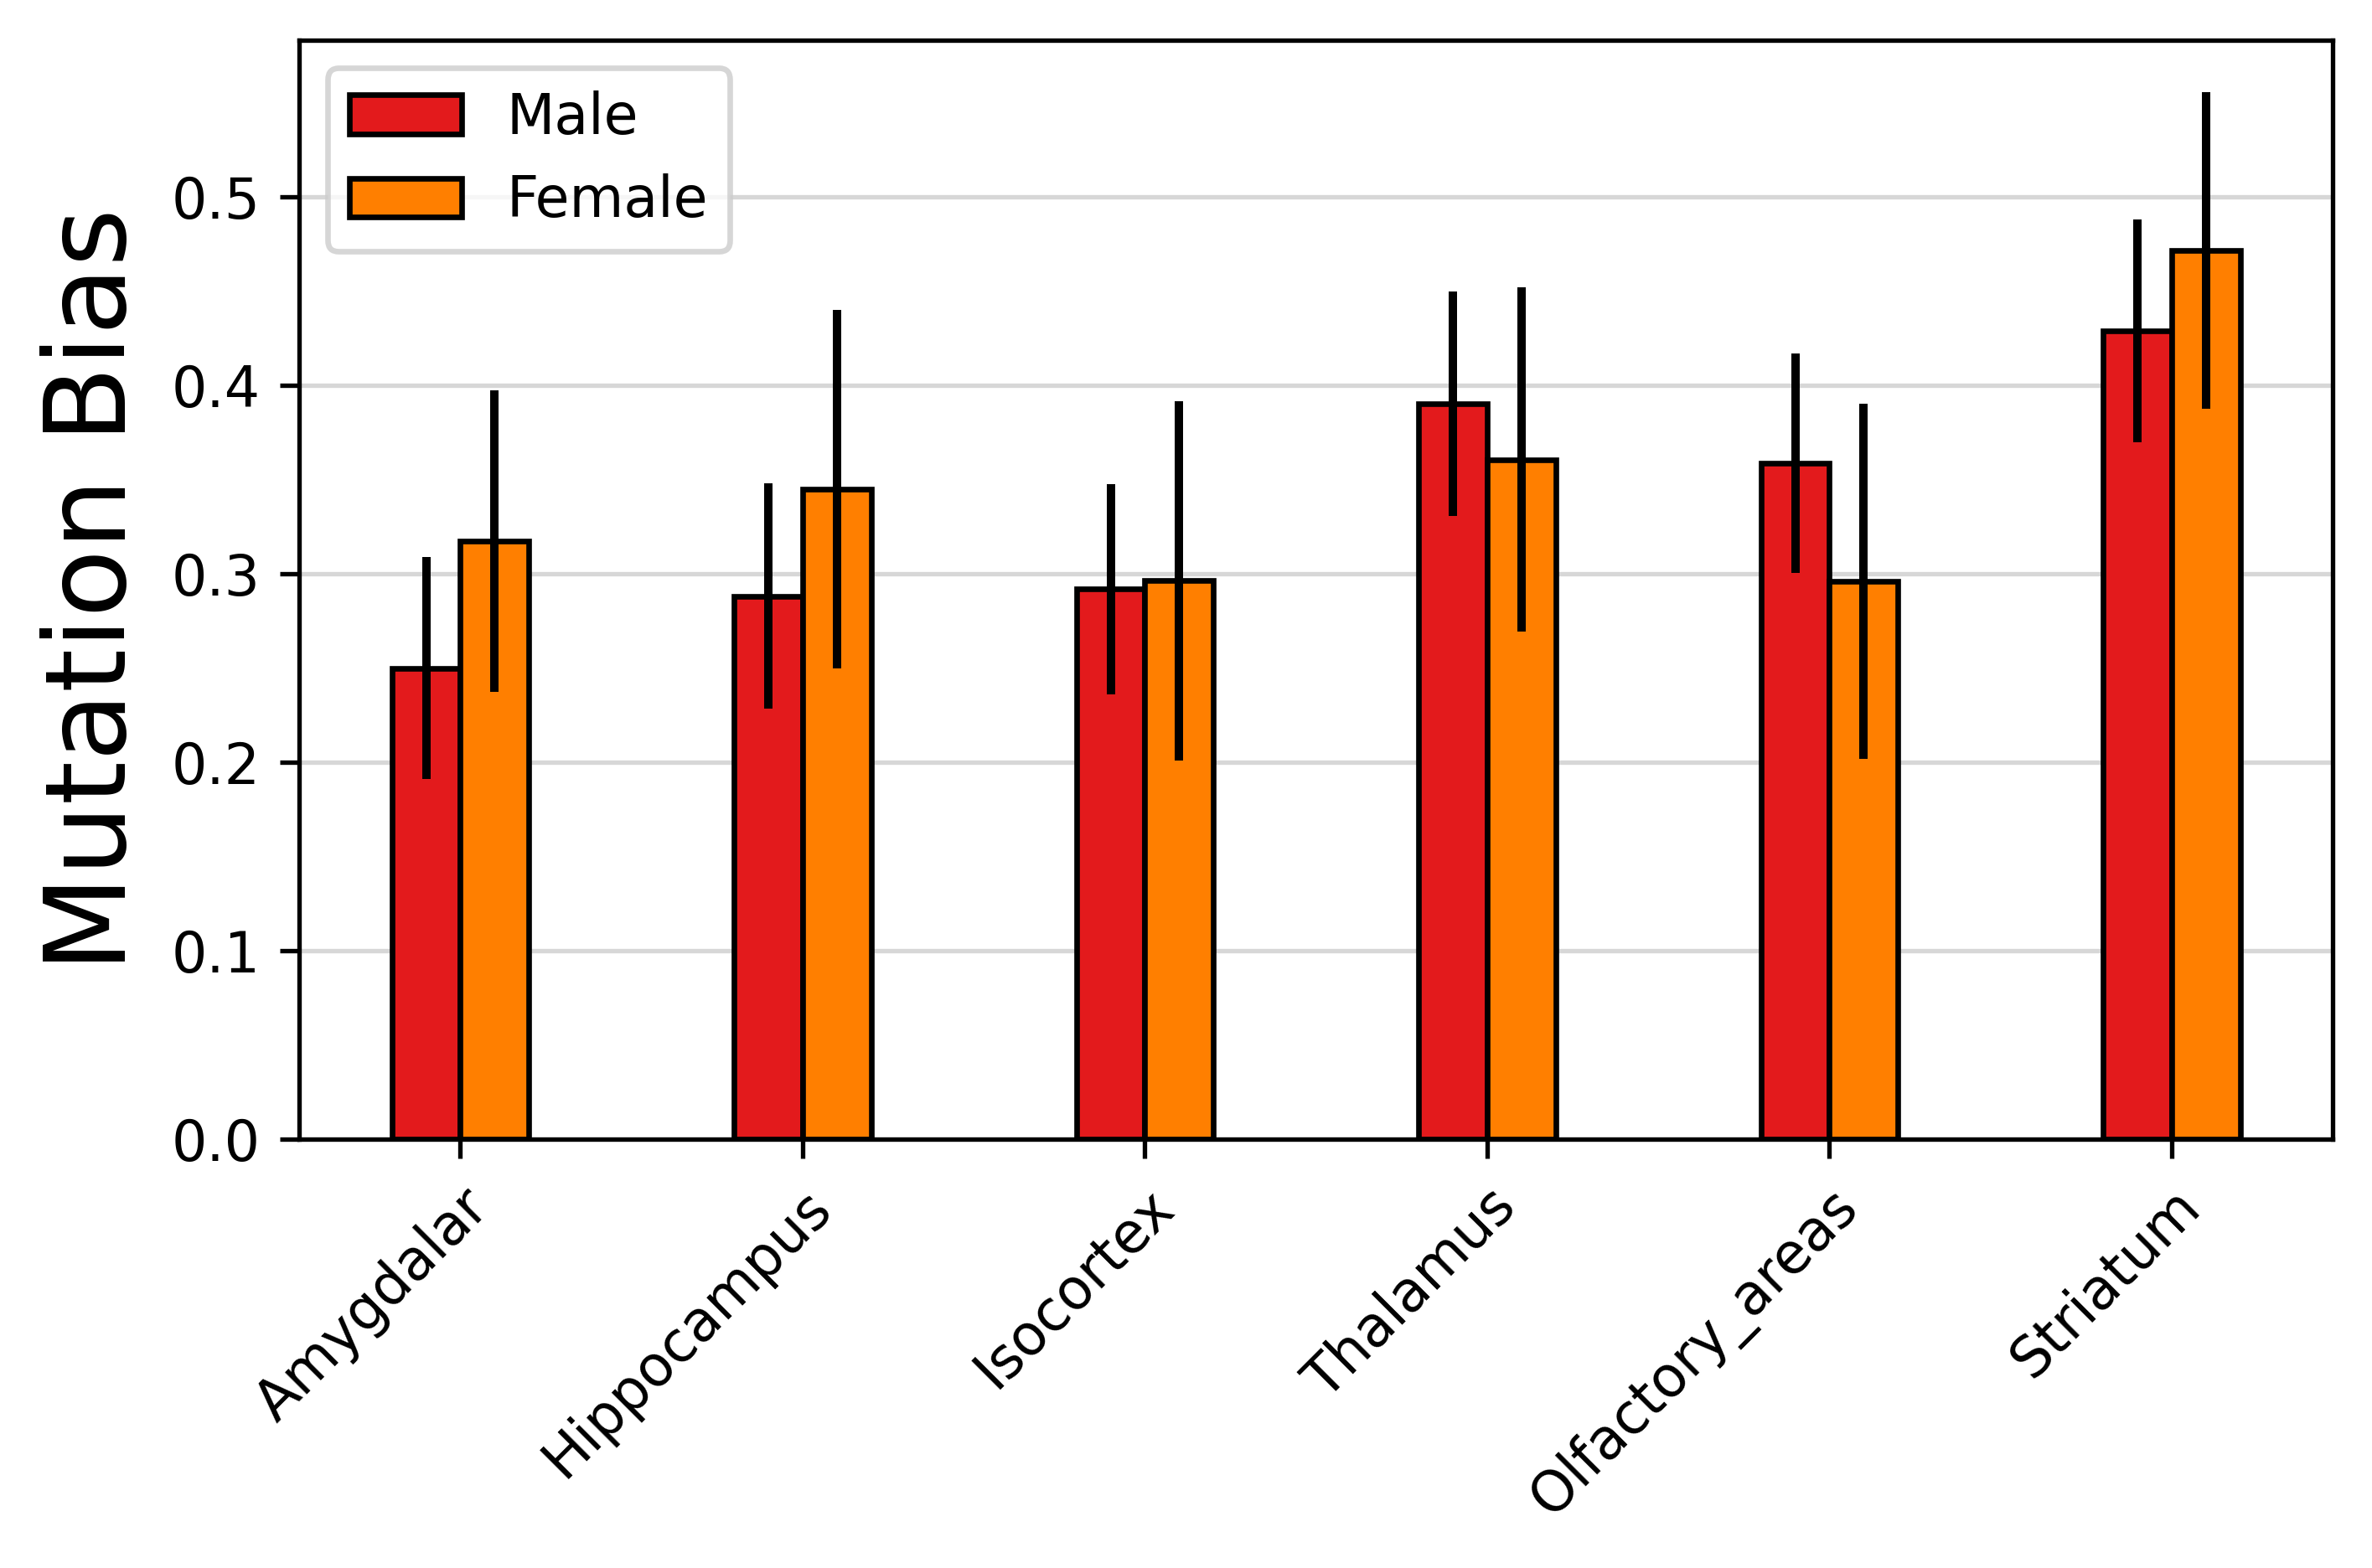

In [527]:

CIR_REGIONS__ = np.array(CIR_REGIONS)
fig, ax = plt.subplots(dpi=480)

X = np.arange(len(CIR_REGIONS))

ax.bar(X - 0.1, Male_ALL_dat[sort_idx], yerr=Male_err[sort_idx], color="#e31a1c", width=0.2, label="Male", 
       edgecolor ='black')
ax.bar(X + 0.1, Female_ALL_dat[sort_idx], yerr=Female_err[sort_idx], color="#ff7f00", width=0.2, label="Female", 
   edgecolor ='black', hatch="")

ax.set_xlabel('', fontweight ='bold', fontsize = 20)
ax.set_ylabel('Mutation Bias', fontsize = 20)
plt.xticks(X, CIR_REGIONS__[sort_idx], rotation=45, fontsize=10, ha='right', rotation_mode="anchor")
  
ax.legend(loc="upper left")
plt.tight_layout()
#ax.set_ylim(0, 0.65)
ax.grid(True, axis="y", alpha=0.5)
ax.set_axisbelow(True)      
#plt.title("Bias - ALL")